### Importing Packages

In [1]:
# Basic packages
import warnings
import requests
import re
import os
import csv
import glob
from pathlib import Path
import datetime
import pytz
import itertools
import numpy as np
import pandas as pd
import kaleido
import requests
import json

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Statistical packages
from scipy.stats import gaussian_kde, kendalltau
import missingno as msno
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from pysal.model import spreg
import dalex as dx
import shap

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, plot, iplot
from plotly.offline import init_notebook_mode
import cufflinks as cf
import palettable.matplotlib as mplpal
import palettable.cmocean.sequential as cmoseqpal
from lime.lime_tabular import LimeTabularExplainer

# Geoplotting packages
import contextily as ctx
from rasterio.plot import show as rioshow
import branca.colormap as cm
import folium
from folium.plugins import HeatMap
from splot import esda as esdasplot
from splot.esda import plot_moran
from legendgram import legendgram

# GIS packages
import fiona
from pyproj import CRS
import xyzservices.providers as xyz
import geopandas as gpd
from geopandas.tools import geocode
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon
from shapely.ops import nearest_points
import mapclassify as mc
from pysal.lib import weights, cg
from pysal.explore import esda
import osmnx as ox

### General Set-up

In [4]:
fiona.supported_drivers

{'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'raw',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'raw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'raw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'raw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

In [5]:
# General set-up
%load_ext watermark
%watermark -i -v -u -co
init_notebook_mode(connected=True)
%matplotlib inline
sns.set_style("white")
plt.style.use("fast")
cf.go_offline()
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', '{:.4f}'.format)
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

Last updated: 2024-09-15T10:38:08.429522+08:00

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.22.2

conda environment: data_analysis_31013



In [6]:
# ctx.providers

In [7]:
# Map settings

# CRS
wgs_crs = CRS.from_epsg(4326)
utm_crs = CRS.from_epsg(3857)

# Map Tiles
jawg_token = os.environ.get('Jawg_Token')
stadia_token = os.environ.get('Stadia_Token')
jawg_url = xyz.Jawg.Matrix.build_url(accessToken=jawg_token)
stadia_url = xyz.Stadia.AlidadeSmoothDark.build_url()
stadia_url = stadia_url + f"?api_key={stadia_token}"
cartodb_url = xyz.CartoDB.Positron.build_url()

In [8]:
px.colors.cyclical.swatches()
px.colors.qualitative.swatches()
px.colors.sequential.swatches()

### Importing Data

#### Geodata from NAMRIA

In [9]:
# Provinces and districts data in Philippines

geo_prov = gpd.read_file('data/geo/2020_boundary_psa/prov/geo_prov.geojson')
geo_ncr = gpd.read_file('data/geo/2020_boundary_psa/reg/geo_reg.geojson')

In [10]:
geo_ncr = geo_ncr.loc[(geo_ncr['region'] == 'NATIONAL CAPITAL REGION (NCR)')].copy().reset_index()

In [11]:
geo_ncr = pd.DataFrame({'prov': ['NCR'], 
                        'geometry': [geo_ncr.rename(columns={'region': 'prov'}).\
                                     drop(columns=['index', 'id', 'psgc_region']).unary_union]})

In [12]:
geo_prov = geo_prov.drop(columns=['psgc_region', 'psgc_province', 'id', 'region'])

In [13]:
geo_prov = geo_prov.rename(columns={'province': 'prov'})

In [14]:
geo_prov = geo_prov.replace({
    'prov':{
        'Cotabato (North Cotabato)': 'Cotabato',
        'Davao de Oro (Compostela Valley)': 'Davao de Oro',
        'Samar (Western Samar)': 'Samar'
    }
})

In [15]:
geo_prov['CE_ID'] = [f'CE_ID_{geo_prov.index[i]}' for i in range(geo_prov.shape[0])]

In [16]:
geo_prov = geo_prov.set_index('prov').drop(index=['Third District, NCR', 'Fourth District, NCR',
                                  'First District, NCR', 'Second District, NCR']).reset_index()

In [17]:
# geo_prov.to_file('../data/geo/2020_boundary_namria/geo_prov.shp')

In [18]:
geo_prov_df = pd.DataFrame(geo_prov)

In [19]:
geo_prov = pd.concat(objs=[geo_prov_df, geo_ncr], axis='index', join='inner').reset_index(drop=True)

In [20]:
np.sort(geo_prov['prov'].unique())

array(['Abra', 'Agusan del Norte', 'Agusan del Sur', 'Aklan', 'Albay',
       'Antique', 'Apayao', 'Aurora', 'Basilan', 'Bataan', 'Batanes',
       'Batangas', 'Benguet', 'Biliran', 'Bohol', 'Bukidnon', 'Bulacan',
       'Cagayan', 'Camarines Norte', 'Camarines Sur', 'Camiguin', 'Capiz',
       'Catanduanes', 'Cavite', 'Cebu', 'Cotabato', 'Davao Occidental',
       'Davao Oriental', 'Davao de Oro', 'Davao del Norte',
       'Davao del Sur', 'Dinagat Islands', 'Eastern Samar', 'Guimaras',
       'Ifugao', 'Ilocos Norte', 'Ilocos Sur', 'Iloilo', 'Isabela',
       'Kalinga', 'La Union', 'Laguna', 'Lanao del Norte',
       'Lanao del Sur', 'Leyte', 'Maguindanao', 'Marinduque', 'Masbate',
       'Misamis Occidental', 'Misamis Oriental', 'Mountain Province',
       'NCR', 'Negros Occidental', 'Negros Oriental', 'Northern Samar',
       'Nueva Ecija', 'Nueva Vizcaya', 'Occidental Mindoro',
       'Oriental Mindoro', 'Palawan', 'Pampanga', 'Pangasinan', 'Quezon',
       'Quirino', 'Rizal', 'Ro

In [21]:
geo_prov = gpd.GeoDataFrame(geo_prov)

In [22]:
# for province in geo_prov.prov:
#     gdf_dummy = geo_prov.loc[geo_prov['prov'] == province]
#     gdf_dummy.to_file(f'../data/geo/2020_boundary_psa/prov/individual/{province}.shp')

#### Provincial Gross Domestic Product per Capita (At Current Prices) - Philippine Statistics Authority, 2020

In [23]:
gdp_pc = pd.read_csv('data/gdp/gpdp_pc.csv')

In [24]:
gdp_pc = gdp_pc.rename(columns={'Geolocation': 'prov', 'Per Capita Gross Domestic Product': 'gdp_pc', 'Year': 'year'})\
                        .drop(labels=[' by Province and HUC', 'Type of Valuation'], axis='columns')

In [25]:
gdp_pc = gdp_pc.loc[gdp_pc['year'] == 2020].reset_index(drop=True)

In [26]:
gdp_pc['prov'] = gdp_pc['prov'].str.replace('..', '')

In [27]:
gdp_pc = gdp_pc.drop(index=gdp_pc[gdp_pc.prov.str.contains(pat='Region', flags=re.IGNORECASE, regex=True)].index)\
                    .reset_index(drop=True)

gdp_pc = gdp_pc.drop(index=gdp_pc[gdp_pc.prov.str.contains(pat='City', flags=re.IGNORECASE, regex=True)].index)\
                    .reset_index(drop=True).drop(columns='year')

#### List of Provinces

In [28]:
prov = list(gdp_pc.prov.unique())

prov

['Abra',
 'Apayao',
 'Benguet',
 'Ifugao',
 'Kalinga',
 'Mountain Province',
 'Ilocos Norte',
 'Ilocos Sur',
 'La Union',
 'Pangasinan',
 'Batanes',
 'Cagayan',
 'Isabela',
 'Nueva Vizcaya',
 'Quirino',
 'Aurora',
 'Bataan',
 'Bulacan',
 'Nueva Ecija',
 'Pampanga',
 'Tarlac',
 'Zambales',
 'Batangas',
 'Cavite',
 'Laguna',
 'Quezon',
 'Rizal',
 'Marinduque',
 'Occidental Mindoro',
 'Oriental Mindoro',
 'Palawan',
 'Romblon',
 'Albay',
 'Camarines Norte',
 'Camarines Sur',
 'Catanduanes',
 'Masbate',
 'Sorsogon',
 'Aklan',
 'Antique',
 'Capiz',
 'Guimaras',
 'Iloilo',
 'Negros Occidental',
 'Bohol',
 'Cebu',
 'Negros Oriental',
 'Siquijor',
 'Biliran',
 'Eastern Samar',
 'Leyte',
 'Northern Samar',
 'Samar',
 'Southern Leyte',
 'Zamboanga del Norte',
 'Zamboanga del Sur',
 'Zamboanga Sibugay',
 'Bukidnon',
 'Camiguin',
 'Lanao del Norte',
 'Misamis Occidental',
 'Misamis Oriental',
 'Davao de Oro',
 'Davao del Norte',
 'Davao del Sur',
 'Davao Occidental',
 'Davao Oriental',
 'Cotabato'

#### Provincial Gross Domestic Product per Industry (At Current Prices) Philippine Statistics Authority, 2020

In [29]:
gpdp = pd.read_csv('data/gdp/gpdp.csv')

In [30]:
gpdp = gpdp.rename(columns={'Geolocation': 'prov', 'At Current Prices 2020': 'gpdp', 'Sector': 'sector'})\
            .drop(['At Current Prices 2018', 'At Current Prices 2019', 'At Current Prices 2021',
                   'At Current Prices 2022'], axis='columns')

In [31]:
gpdp['prov'] = gpdp['prov'].str.replace('..', '')

In [32]:
gpdp = gpdp.drop(index=gpdp[gpdp.prov.str.contains(pat='Region', flags=re.IGNORECASE, regex=True)].index)\
                    .reset_index(drop=True)

gpdp = gpdp.drop(index=gpdp[gpdp.prov.str.contains(pat='City', flags=re.IGNORECASE, regex=True)].index)\
                    .reset_index(drop=True)

In [33]:
gpdp.sector.unique()

array(['Agriculture, Forestry, and Fishing', 'Mining and Quarrying',
       'Manufacturing', 'Electricity, Steam, Water and Waste Management',
       'Construction',
       'Wholesale and Retail Trade; Repair of Motor Vehicles and Motorcycles',
       'Transportation and Storage',
       'Accommodation and Food Service Activities',
       'Information and Communication',
       'Financial and Insurance Activities',
       'Real Estate and Ownership of Dwellings',
       'Professional and Business Services',
       'Public Administration and Defense; Compulsory Social Activities',
       'Education', 'Human Health and Social Work Activities',
       'Other Services'], dtype=object)

In [34]:
agri_ind = ['Agriculture, Forestry, and Fishing']
indu_ind = ['Mining and Quarrying','Manufacturing', 'Electricity, Steam, Water and Waste Management', 'Construction']
serv_ind = ['Wholesale and Retail Trade; Repair of Motor Vehicles and Motorcycles', 'Transportation and Storage',
            'Accommodation and Food Service Activities', 'Information and Communication', 'Financial and Insurance Activities',
            'Real Estate and Ownership of Dwellings', 'Professional and Business Services',
            'Public Administration and Defense; Compulsory Social Activities',
            'Education', 'Human Health and Social Work Activities', 'Other Services']

In [35]:
gpdp_agri = gpdp[gpdp.sector.isin(agri_ind)].reset_index(drop=True)
gpdp_indu = gpdp[gpdp.sector.isin(indu_ind)].reset_index(drop=True)
gpdp_serv = gpdp[gpdp.sector.isin(serv_ind)].reset_index(drop=True)

In [36]:
gpdp_agri = gpdp_agri.groupby(by='prov').agg({'gpdp': sum}).reset_index().rename(columns={'gpdp': 'gpdp_agri'})
gpdp_indu = gpdp_indu.groupby(by='prov').agg({'gpdp': sum}).reset_index().rename(columns={'gpdp': 'gpdp_indu'})
gpdp_serv = gpdp_serv.groupby(by='prov').agg({'gpdp': sum}).reset_index().rename(columns={'gpdp': 'gpdp_serv'})

In [37]:
gpdp = pd.concat(objs=[df.set_index('prov') for df in [gpdp_agri, gpdp_indu, gpdp_serv]],
          axis='columns', join='inner').reset_index()

In [38]:
gdp_pc

prov      gdp_pc
0                    Abra  85404.4000
1                  Apayao  86660.9900
2                 Benguet 148723.1900
3                  Ifugao 114854.9300
4                 Kalinga 109590.6200
..                    ...         ...
78            Maguindanao 106884.4000
79  Maguindanao del Norte  61681.1400
80    Maguindanao del Sur  45203.2600
81                   Sulu  47459.7200
82              Tawi-Tawi  57436.7800

[83 rows x 2 columns]

In [39]:
df = pd.concat(objs=[df.set_index('prov') for df in [gpdp, gdp_pc]],
          axis='columns', join='inner').reset_index()

In [40]:
df_ncr = pd.DataFrame({'prov': ['NCR'], 'gpdp_agri': [450942], 'gpdp_indu': [1096049972],
                       'gpdp_serv': [4704318265], 'gdp_pc': [420207.441538838]})

In [41]:
df = pd.concat(objs=[df,df_ncr], axis='index', join='inner').reset_index(drop=True)

In [42]:
df['gpdp_agri'] = df['gpdp_agri'].astype(np.float64)
df['gpdp_indu'] = df['gpdp_indu'].astype(np.float64)
df['gpdp_serv'] = df['gpdp_serv'].astype(np.float64)
df['gdp_pc'] = df['gdp_pc'].astype(np.float64)

#### Water Resources (cu.m per month) - Local Water Utility Administration, 2020

In [43]:
water = pd.read_csv('data/water_lwua/water.csv')

In [44]:
water = water.rename(columns={'Province': 'prov', 'Production m3/month': 'water_prod',
                              'Service Connections': 'water_serv_conn', 
                              'Population Served': 'water_pop_serv', 
                              'Ave. Cons. m3/month': 'water_ave_cons'})
water = water.drop(columns=['Region', 'Operational WD Count', 'Surface', 'Wells', 'Springs',
                            'Min. Charge', '11-20 m3', '21-30 m3','31-40 m3', '41-50 m3',
                            '51-up m3', 'Cost per 20 m3','Cost per 30 m3'])

In [45]:
water = water.replace({'prov':{'Agusan Del Norte': 'Agusan del Norte', 'Agusan Del Sur': 'Agusan del Sur', 
                    'Compostela Valley': 'Davao de Oro', 'Davao (Del Norte)': 'Davao del Norte', 
                    'Davao Del Sur': 'Davao del Sur', 'Lanao Del Norte': 'Lanao del Norte', 
                    'Lanao Del Sur': 'Lanao del Sur', 'North Cotabato': 'Cotabato', 
                    'Surigao Del Norte': 'Surigao del Norte', 'Surigao Del Sur': 'Surigao del Sur', 
                    'Tawi Tawi': 'Tawi-Tawi', 'Western Samar': 'Samar', 'Zamboanga Del Norte': 'Zamboanga del Norte', 
                    'Zamboanga Del Sur': 'Zamboanga del Sur'}})

#### Due to data limitation on NCR districts, Maguindanao Del Sur, and Maguindanao Del Norte

In [46]:
gpdp_agri_mag = np.array(df.loc[df['prov'] == 'Maguindanao del Norte']['gpdp_agri'])[0] + \
                np.array(df.loc[df['prov'] == 'Maguindanao del Sur']['gpdp_agri'])[0]
gpdp_indu_mag = np.array(df.loc[df['prov'] == 'Maguindanao del Norte']['gpdp_indu'])[0] + \
                np.array(df.loc[df['prov'] == 'Maguindanao del Sur']['gpdp_indu'])[0]
gpdp_serv_mag = np.array(df.loc[df['prov'] == 'Maguindanao del Norte']['gpdp_serv'])[0] + \
                np.array(df.loc[df['prov'] == 'Maguindanao del Sur']['gpdp_serv'])[0]
gdp_pc_mag = np.array(df.loc[df['prov'] == 'Maguindanao del Norte']['gdp_pc'])[0] + \
                np.array(df.loc[df['prov'] == 'Maguindanao del Sur']['gdp_pc'])[0]

df_maguindanao = pd.DataFrame({'prov': ['Maguindanao'], 'gpdp_agri': [gpdp_agri_mag], 'gpdp_indu': [gpdp_indu_mag],
                       'gpdp_serv': [gpdp_serv_mag], 'gdp_pc': [gdp_pc_mag]})

# df = pd.concat(objs=[df,df_maguindanao], axis='index', join='inner').reset_index(drop=True)

In [47]:
df.loc[:, 'water_prod'] = np.nan

In [48]:
water['water_prod'] = water['water_prod'].str.replace(',','')
water['water_serv_conn'] = water['water_serv_conn'].str.replace(',','')
water['water_pop_serv'] = water['water_pop_serv'].str.replace(',','')

In [49]:
water['water_prod'] = water['water_prod'].astype(np.float64)
water['water_serv_conn'] = water['water_serv_conn'].astype(np.float64)
water['water_pop_serv'] = water['water_pop_serv'].astype(np.float64)

In [50]:
def insert_data(df_1, df_2, data):
    if type(data) == list:
        for i in range(len(data)):
            for province in df_2.prov.unique():
                if province in prov:
                    df_1.loc[df_1['prov'] == province, data[i]] = np.array(df_2.loc[df_2['prov'] == province, data[i]])[0]
                elif province == 'NCR':
                    df_1.loc[df_1['prov'] == province, data[i]] = np.array(df_2.loc[df_2['prov'] == province, data[i]])[0]
    else:
        for province in df_2.prov.unique():
            if province in prov:
                df_1.loc[df_1['prov'] == province, data] = np.array(df_2.loc[df_2['prov'] == province, data])[0]
            elif province == 'NCR':
                df_1.loc[df_1['prov'] == province, data] = np.array(df_2.loc[df_2['prov'] == province, data])[0]

In [51]:
insert_data(df, water, ['water_prod', 'water_serv_conn', 'water_pop_serv', 'water_ave_cons'])

#### Power Supply - Department of Energy, 2020

In [52]:
power = pd.read_csv('data/2020_pwr_doe/power.csv')
power_elp = pd.read_csv('data/pwr_elp/power.csv')

In [53]:
power = power.replace(
    {
        'prov':{
            'BUkidnon': 'Bukidnon',
            ' Nueva Ecija': 'Nueva Ecija',
            'Bataaan': 'Bataan',
            ' Isabela': 'Isabela'
        }
    })

power = power.rename(
    columns={
        'dep_cap': 'pwr_dep',
        'inst_cap': 'pwr_inst'
    }
)

power_elp = power_elp.rename(columns={'province': 'prov'}).replace({
    'prov': {
        'Agusan Del Norte': 'Agusan del Norte',
        'Agusan Del Sur': 'Agusan del Sur',
        'Davao De Oro': 'Davao de Oro',
        'Davao Del Norte': 'Davao del Norte',
        'Davao Del Sur': 'Davao del Sur',
        'Lanao Del Norte': 'Lanao del Norte',
        'Lanao Del Sur': 'Lanao del Sur',
        'Nueva Viscaya': 'Nueva Vizcaya',
        'Surigao Del Norte': 'Surigao del Norte',
        'Surigao Del Sur': 'Surigao del Sur',
        'Zamboanga Del Norte': 'Zamboanga del Norte',
        'Zamboanga Del Sur': 'Zamboanga del Sur'
    }
})

In [54]:
power = power.groupby(by='prov').agg(sum).reset_index()[['prov', 'pwr_inst', 'pwr_dep']]

In [55]:
power_elp = power_elp.rename(columns={'pwr_inst': 'pwr_inst_elp', 'pwr_dep': 'pwr_dep_elp'})
power_elp = power_elp[['prov', 'pwr_inst_elp', 'pwr_dep_elp']]

In [56]:
df.loc[:, 'pwr_inst'] = np.nan
df.loc[:, 'pwr_dep'] = np.nan
df.loc[:, 'pwr_inst_elp'] = np.nan
df.loc[:, 'pwr_dep_elp'] = np.nan

In [57]:
insert_data(df, power, ['pwr_inst', 'pwr_dep'])
insert_data(df, power_elp, ['pwr_inst_elp', 'pwr_dep_elp'])

#### Climate data from ClimateEngine.org

In [58]:
ce_api = os.environ.get('climateengine_api')

##### Climate Engine Timeseries Native Polygon Dataset

In [59]:
# Dataset (dataset) = MODIS_TERRA_DAILY
# Variable (variable) = Land Surface Temperature (LST_Day_1km)
# Variable (variable) = Precipitation (CHIRPS_PENTAD)
# Area Reducer (area_reducer) = mean, median or maximum
# Start Date (start_date) = 2018-01-01
# End Date (end_date) = 2023-12-31
# Coordinates (coordinates) = NAMRIA provincial geometries

##### Land Surface Mean Temperature

In [60]:
lsat = pd.read_csv('data/climate/lsat/lsat.csv')

In [61]:
lsat = lsat.drop(columns=['Unnamed: 0'])

In [62]:
lsat = pd.DataFrame(lsat.mean()).reset_index().rename(columns={'index': 'prov', 0: 'lsat'})

In [63]:
np.sort(lsat.prov.unique())

array(['Abra', 'Agusan del Norte', 'Agusan del Sur', 'Aklan', 'Albay',
       'Antique', 'Apayao', 'Aurora', 'Basilan', 'Bataan', 'Batanes',
       'Batangas', 'Benguet', 'Biliran', 'Bohol', 'Bukidnon', 'Bulacan',
       'Cagayan', 'Camarines Norte', 'Camarines Sur', 'Camiguin', 'Capiz',
       'Catanduanes', 'Cavite', 'Cebu', 'Cotabato', 'Davao Occidental',
       'Davao Oriental', 'Davao de Oro', 'Davao del Norte',
       'Davao del Sur', 'Dinagat Islands', 'Eastern Samar', 'Guimaras',
       'Ifugao', 'Ilocos Norte', 'Ilocos Sur', 'Iloilo', 'Isabela',
       'Kalinga', 'La Union', 'Laguna', 'Lanao del Norte',
       'Lanao del Sur', 'Leyte', 'Maguindanao', 'Marinduque', 'Masbate',
       'Misamis Occidental', 'Misamis Oriental', 'Mountain Province',
       'NCR', 'Negros Occidental', 'Negros Oriental', 'Northern Samar',
       'Nueva Ecija', 'Nueva Vizcaya', 'Occidental Mindoro',
       'Oriental Mindoro', 'Palawan', 'Pampanga', 'Pangasinan', 'Quezon',
       'Quirino', 'Rizal', 'Ro

In [64]:
df.loc[:, 'lsat'] = np.nan

In [65]:
for province in lsat.prov.unique():
    if province in prov:
        df.loc[df['prov'] == province, 'lsat'] = np.array(lsat.loc[lsat['prov'] == province, 'lsat'])[0]
    elif province == 'NCR':
        df.loc[df['prov'] == province, 'lsat'] = np.array(lsat.loc[lsat['prov'] == province, 'lsat'])[0]

In [66]:
ce_root_url = 'https://api.climateengine.org/'
ce_end = 'timeseries/native/polygons'
ce_header = {'Authorization': ce_api}

# ce_lsat_mean_params = {'dataset': 'MODIS_TERRA_DAILY', 'variable': 'LST_Day_1km', 'area_reducer': 'mean',
#                        'start_date': '2023-12-21', 'end_date': '2023-12-31', 'coordinate': albay_list}

In [67]:
# ce_lsat_mean_albay_inst = requests.get(url=ce_root_url + ce_end, params=ce_lsat_mean_params, headers=ce_header, verify=False)

In [68]:
# ce_lsat_mean_albay_inst.status_code == requests.code.ok

In [69]:
# ce_lsat_albay = ce_lsat_mean_albay_inst.json()

#### Working Population - PSA, 2020

In [70]:
work_pop = pd.read_csv('data/2020_pop_psa/pop.csv')

In [71]:
df.loc[:, 'work_pop'] = np.nan
df.loc[:, 'pop'] = np.nan

In [72]:
insert_data(df, work_pop, ['work_pop', 'pop'])

#### Roads - Openstreetmap, 2020

In [73]:
# Data from last day of 2020

ox.settings.overpass_settings = '[out:json][timeout:90][date:"2020-12-31T19:20:00Z"]'

In [74]:
# geo_prov.loc[:, 'road_len'] = np.nan
# geo_prov.loc[:, 'area'] = np.nan

In [75]:
# geo_prov = geo_prov.set_crs(epsg=4326)

In [76]:
# geo_prov_cea = geo_prov.copy().to_crs({'proj':'cea'})

In [77]:
# geo_prov['area'] = geo_prov_cea.area / 10**6

##### Summarizing road lengths

In [78]:
# for i in range(geo_prov.shape[0]):
#     dummy_inst = ox.graph_from_polygon(geo_prov.iloc[i][1], network_type='all')
#     dummy_nodes, dummy_edges = ox.graph_to_gdfs(dummy_inst)
#     road_len = dummy_edges.reset_index(drop=True).rename(columns={'length': 'len'})['len'].sum()
#     geo_prov.loc[geo_prov['prov'] == geo_prov.iloc[i][0], 'road_len'] = road_len
#     road_len = 0

In [79]:
# geo_prov.to_csv('../data/2020_pop_psa/pop_road.csv')

#### Land Use - Openstreetmap, 2020

##### Summarizing residential land use

In [80]:
# geo_prov.loc[:, 'hh_area'] = np.nan

In [81]:
# for i in range(geo_prov.shape[0]):
#     hh_area_inst = ox.features_from_polygon(geo_prov.iloc[i][1], tags={'landuse': 'residential'}).reset_index().to_crs({'proj':'cea'})
#     hh_area = (hh_area_inst.area).sum()
#     geo_prov.loc[geo_prov['prov'] == geo_prov.iloc[i][0], 'hh_area'] = hh_area
#     hh_area = 0

In [82]:
# geo_prov.to_csv('../data/2020_pop_psa/pop_road_hharea.csv')

In [83]:
geo_prov_hharea = pd.read_csv('data/2020_pop_psa/pop_road_hharea.csv')
geo_prov_road = pd.read_csv('data/2020_pop_psa/pop_road.csv')

In [84]:
geo_prov_road = geo_prov_road.drop(columns=['Unnamed: 0', 'geometry'])
geo_prov_hharea = geo_prov_hharea.drop(columns=['Unnamed: 0', 'geometry', 'road_len', 'area'])

In [85]:
geo_prov = geo_prov.merge(right=geo_prov_road, how='inner', on='prov').merge(right=geo_prov_hharea, how='inner', on='prov')

In [86]:
geo_prov.loc[:, 'road_dens'] = np.nan
geo_prov.loc[:, 'hh_dens'] = np.nan

In [87]:
geo_prov['road_dens'] = geo_prov['road_len'] / geo_prov['area']
geo_prov['hh_dens'] = geo_prov['hh_area'] / geo_prov['area']

In [88]:
drop_1 = geo_prov.loc[(geo_prov['prov'] == 'Basilan') & (geo_prov['area'] == 221.8261123886724)].index.append(\
    geo_prov.loc[(geo_prov['prov'] == 'Southern Leyte') & (geo_prov['area'] == 138.7886616358953)].index).append(\
    geo_prov.loc[(geo_prov['prov'] == 'Maguindanao') & (geo_prov['area'] == 83.31069549858286)].index)

In [89]:
geo_prov = geo_prov.drop(index=drop_1).drop_duplicates(subset='area', keep='first').reset_index(drop=True)

In [90]:
df = df.merge(right=geo_prov, how='inner', on='prov')

In [91]:
df['pop_dens'] = df['pop'] / df['area']

In [92]:
df.columns

Index(['prov', 'gpdp_agri', 'gpdp_indu', 'gpdp_serv', 'gdp_pc', 'water_prod',
       'water_serv_conn', 'water_pop_serv', 'water_ave_cons', 'pwr_inst',
       'pwr_dep', 'pwr_inst_elp', 'pwr_dep_elp', 'lsat', 'work_pop', 'pop',
       'geometry', 'road_len', 'area', 'hh_area', 'road_dens', 'hh_dens',
       'pop_dens'],
      dtype='object')

In [93]:
gdf = gpd.GeoDataFrame(df).set_crs(4326, allow_override=True)

gdf_imp = gdf.copy().drop(columns=['prov', 'gpdp_agri', 'gpdp_indu', 'gpdp_serv', 
                                 'water_serv_conn', 'water_pop_serv', 'water_ave_cons',
                                 'pwr_inst', 'pwr_dep', 'pwr_inst_elp', 'work_pop', 'pop',
                                   'geometry', 'road_len', 'area', 'hh_area'])

gdf_imp = gdf_imp.sort_index(axis='columns')

In [94]:
gdf_imp.columns

Index(['gdp_pc', 'hh_dens', 'lsat', 'pop_dens', 'pwr_dep_elp', 'road_dens',
       'water_prod'],
      dtype='object')

In [95]:
dep_var = list(gdf_imp.copy().drop(columns=['gdp_pc']).columns)
ds = 'ph_data'

### Missing Data Handling

<Axes: >

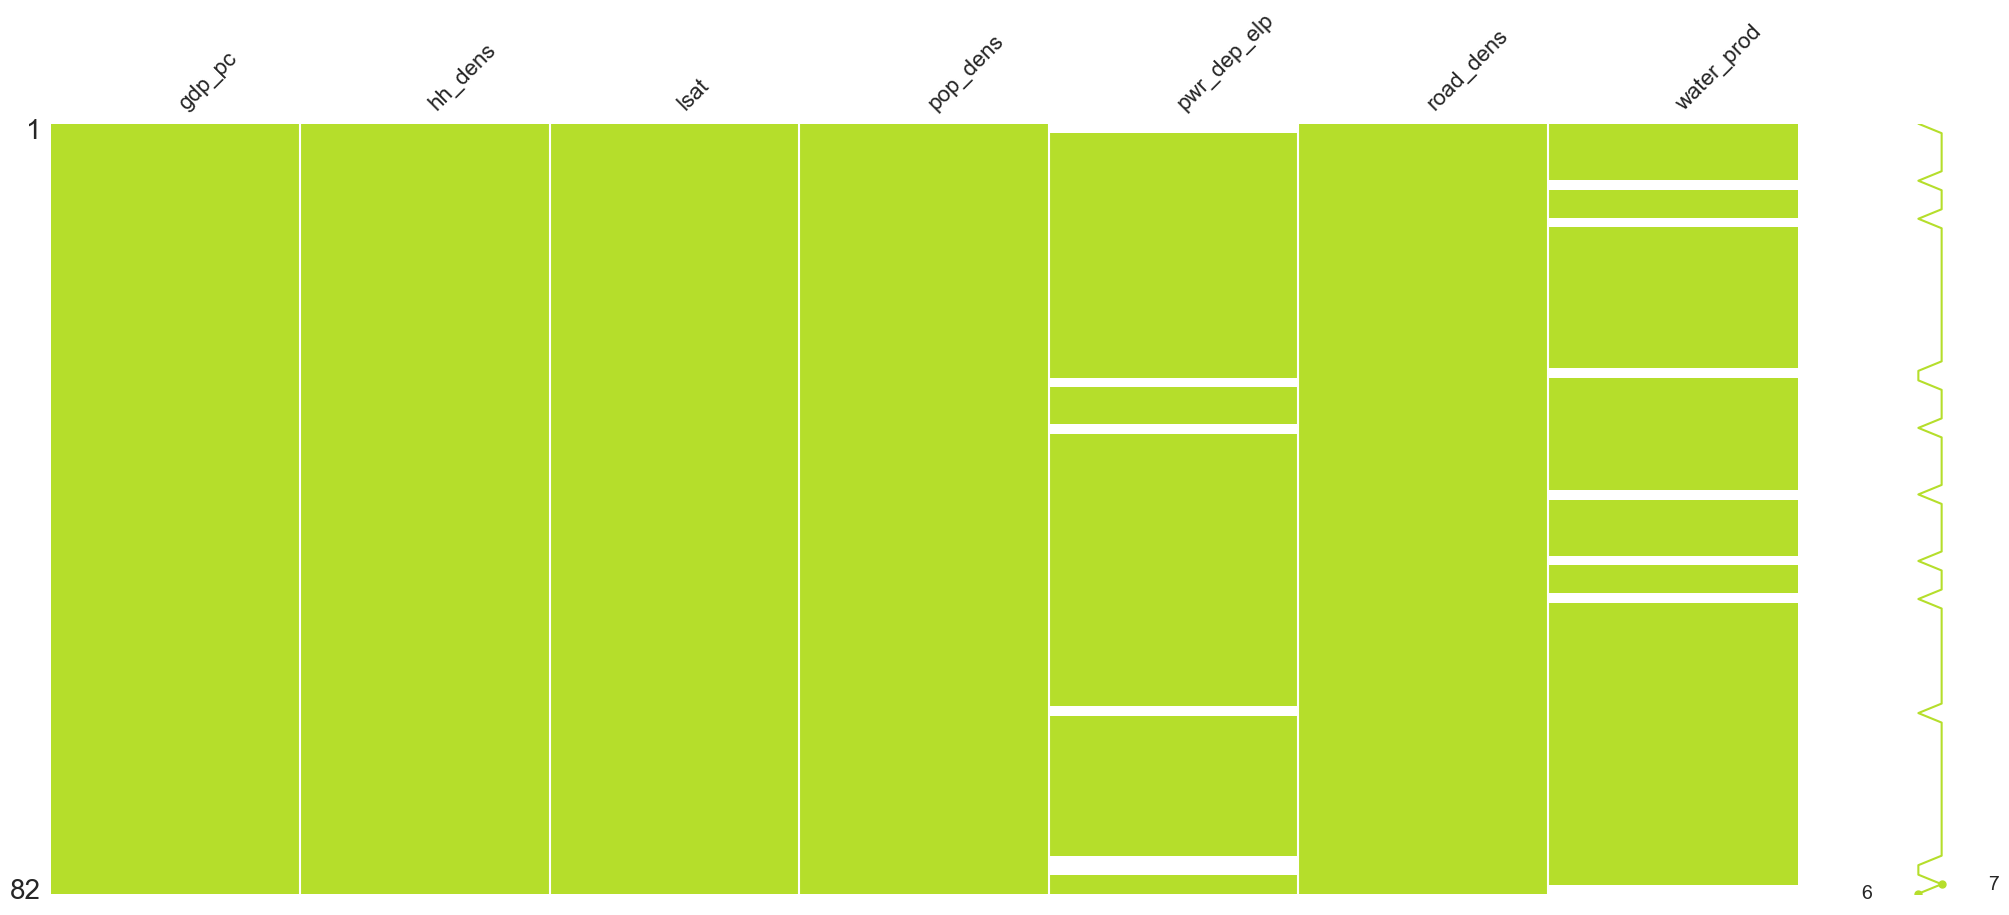

In [96]:
msno.matrix(df=gdf_imp, color=(181/255, 222/255, 43/255))

In [97]:
rf = RandomForestRegressor(n_estimators=1000, max_features=gdf_imp.shape[1], random_state=300)

In [98]:
imp_rf = IterativeImputer(estimator=rf, random_state=300)

In [99]:
imp_res = imp_rf.fit_transform(gdf_imp)

In [100]:
gdf_impd = gpd.GeoDataFrame(imp_res)

In [101]:
gdf_impd.columns = list(gdf_imp.columns)

In [102]:
gdf_impd.columns

Index(['gdp_pc', 'hh_dens', 'lsat', 'pop_dens', 'pwr_dep_elp', 'road_dens',
       'water_prod'],
      dtype='object')

In [103]:
gdf.columns

Index(['prov', 'gpdp_agri', 'gpdp_indu', 'gpdp_serv', 'gdp_pc', 'water_prod',
       'water_serv_conn', 'water_pop_serv', 'water_ave_cons', 'pwr_inst',
       'pwr_dep', 'pwr_inst_elp', 'pwr_dep_elp', 'lsat', 'work_pop', 'pop',
       'geometry', 'road_len', 'area', 'hh_area', 'road_dens', 'hh_dens',
       'pop_dens'],
      dtype='object')

In [104]:
gdf_fin = gdf_impd.merge(right=gdf.copy().drop(columns=['water_prod', 'water_serv_conn',
                                                        'water_pop_serv', 'water_ave_cons', 'pwr_inst',
                                                        'pwr_dep', 'pwr_inst_elp', 'pwr_dep_elp', 'lsat',
                                                        'work_pop', 'pop', 'road_len', 'area', 'hh_area',
                                                        'road_dens', 'hh_dens', 'pop_dens']),
               how='inner', on='gdp_pc')

<Axes: >

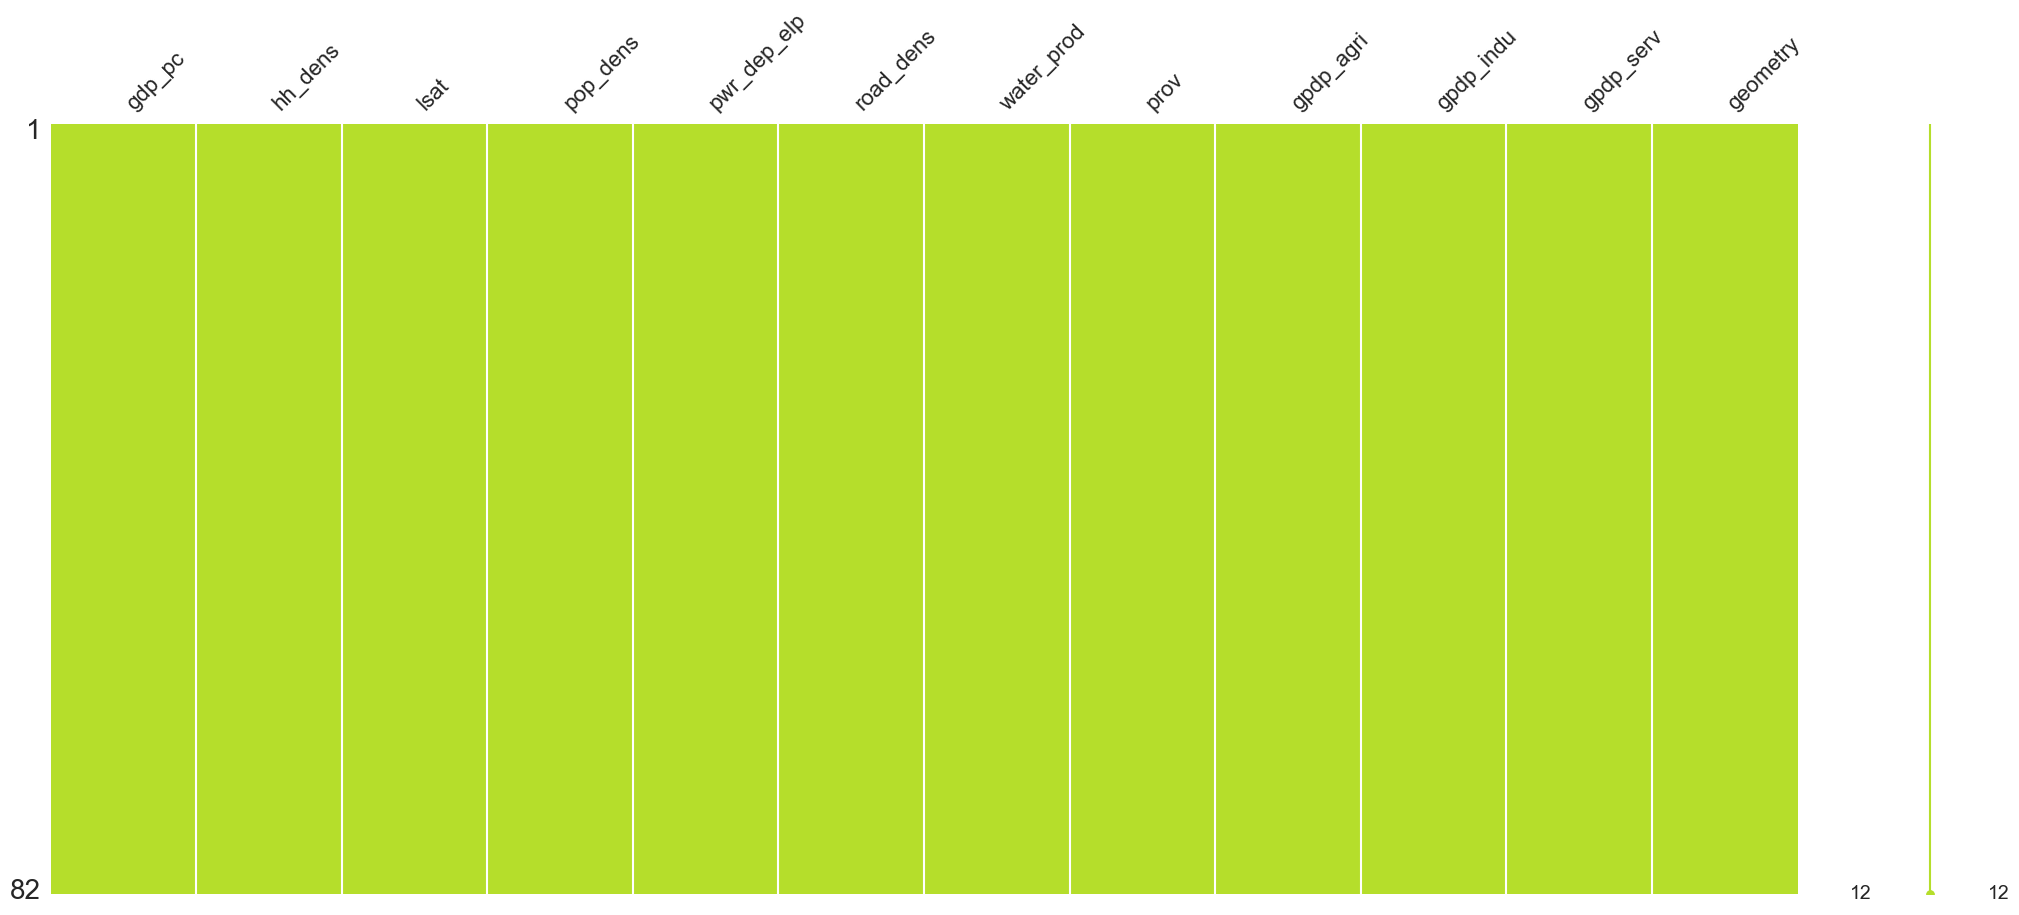

In [105]:
msno.matrix(df=gdf_fin, color=(181/255, 222/255, 43/255))

### Current Conditions

#### Spatial weight

In [106]:
gdf_fin.columns

Index(['gdp_pc', 'hh_dens', 'lsat', 'pop_dens', 'pwr_dep_elp', 'road_dens',
       'water_prod', 'prov', 'gpdp_agri', 'gpdp_indu', 'gpdp_serv',
       'geometry'],
      dtype='object')

In [107]:
gdf_fin['log_gdp_pc'] = gdf_fin['gdp_pc'].apply(np.log)

In [108]:
gdf_sim_x = gdf_fin.copy().drop(index=gdf_fin.loc[gdf_fin['prov'] == 'Batanes'].index[0]).\
                    drop(columns=['log_gdp_pc', 'gdp_pc', 'prov', 'gpdp_agri', 'gpdp_indu', 'gpdp_serv', 'geometry']).reset_index(drop=True)
gdf_sim_y = gdf_fin.copy().drop(index=gdf_fin.loc[gdf_fin['prov'] == 'Batanes'].index[0]).reset_index(drop=True)
gdf_dep_x = gdf_fin.copy().drop(columns=['log_gdp_pc', 'gdp_pc', 'prov', 'gpdp_agri', 'gpdp_indu', 'gpdp_serv', 'geometry'])
gdf_dep_y = gdf_fin.copy()

In [109]:
earth_r = cg.RADIUS_EARTH_KM

In [110]:
wgt_1 = weights.contiguity.Queen.from_dataframe(df=gdf_fin.copy().drop(index=gdf_fin.loc[gdf_fin['prov'] == 'Batanes'].index[0]))
wgt_2 = weights.distance.Kernel.from_dataframe(df=gdf_fin.copy().drop(index=gdf_fin.loc[gdf_fin['prov'] == 'Batanes'].index[0]), k=2, radius=earth_r)
wgt_sim = weights.attach_islands(wgt_1, wgt_2)

In [111]:
wgt_dep = weights.contiguity.Queen.from_dataframe(df=gpd.GeoDataFrame(gdf_fin).set_crs(4326, allow_override=True))

In [112]:
wgt_sim.neighbors

{0: [49, 34, 35, 38, 6, 23],
 1: [48, 73, 2, 72],
 2: [48, 1, 73, 26, 27, 28, 14],
 3: [20, 5],
 4: [18, 67],
 5: [3, 20, 36, 80],
 6: [0, 16, 34, 38],
 7: [53, 54, 37, 60, 61, 15],
 8: [52],
 9: [58, 76],
 10: [40, 60, 22],
 11: [33, 49, 35, 54, 39, 59],
 12: [35, 57],
 13: [57],
 14: [48, 2, 24, 41, 42, 28, 30, 71],
 15: [53, 7, 58, 60, 62],
 16: [34, 37, 38, 6],
 17: [18, 60],
 18: [17, 4, 60],
 19: [38],
 20: [3, 36, 5],
 21: [23],
 22: [40, 10],
 23: [0],
 24: [70, 44, 42, 28, 29, 14, 45],
 25: [65, 29],
 26: [73, 2, 27],
 27: [2, 26, 28],
 28: [2, 24, 27, 29, 14],
 29: [65, 68, 70, 24, 25, 28],
 30: [14],
 31: [64, 52],
 32: [64],
 33: [49, 11, 37, 54],
 34: [0, 16, 35, 6],
 35: [0, 49, 34, 39, 11, 12, 63, 75],
 36: [20, 5],
 37: [16, 33, 49, 38, 7, 54, 61],
 38: [0, 49, 16, 37, 6, 19, 46],
 39: [11, 59, 35],
 40: [62, 10, 60, 22],
 41: [48, 42, 14, 79],
 42: [24, 41, 44, 14],
 43: [69],
 44: [24, 42, 70],
 45: [24],
 46: [38],
 47: [78, 79],
 48: [1, 2, 14, 41],
 49: [0, 33, 35,

In [113]:
wgt_sim.islands

[]

In [114]:
wgt_dep.neighbors

{0: [50, 35, 36, 6, 39],
 1: [73, 49, 2, 74],
 2: [1, 49, 74, 27, 28, 29, 15],
 3: [21, 5],
 4: [19, 68],
 5: [37, 3, 21],
 6: [0, 17, 35, 39],
 7: [16, 54, 55, 38, 61, 62],
 8: [],
 9: [59, 77],
 10: [],
 11: [41, 61, 23],
 12: [34, 50, 36, 55, 40, 60],
 13: [],
 14: [],
 15: [49, 2, 25, 42, 43, 29],
 16: [54, 7, 59, 61, 63],
 17: [38, 35, 6, 39],
 18: [19, 61],
 19: [18, 4, 61],
 20: [],
 21: [5, 3, 37],
 22: [],
 23: [41, 11],
 24: [],
 25: [45, 71, 43, 29, 30, 15],
 26: [66, 30],
 27: [2, 28, 74],
 28: [2, 27, 29],
 29: [2, 25, 28, 30, 15],
 30: [66, 69, 71, 25, 26, 29],
 31: [],
 32: [65, 53],
 33: [],
 34: [50, 12, 38, 55],
 35: [0, 17, 36, 6],
 36: [0, 50, 35, 40, 12],
 37: [21, 5],
 38: [17, 34, 50, 39, 55, 7, 62],
 39: [0, 17, 50, 6, 38],
 40: [36, 12, 60],
 41: [63, 11, 61, 23],
 42: [80, 49, 43, 15],
 43: [25, 42, 45, 15],
 44: [70],
 45: [25, 43, 71],
 46: [],
 47: [],
 48: [80, 79],
 49: [1, 2, 42, 15],
 50: [0, 34, 36, 38, 39, 12],
 51: [52],
 52: [51],
 53: [32, 65],
 54

In [115]:
wgt_dep.islands

[8, 10, 13, 14, 20, 22, 24, 31, 33, 46, 47, 58, 64, 67, 72, 76, 81]

In [116]:
wgt_sim.transform = 'r'

In [117]:
wgt_dep.transform = 'r'

('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 31, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 46, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 64, ' is an island (no neighbors)')
('WARNING: ', 67, ' is an island (no neighbors)')
('WARNING: ', 72, ' is an island (no neighbors)')
('WARNING: ', 76, ' is an island (no neighbors)')
('WARNING: ', 81, ' is an island (no neighbors)')


In [118]:
# wgt_dep = weights.insert_diagonal(wgt_dep, np.zeros(wgt_dep.n))

In [119]:
sim_w_name = 'attached_islands'
dep_w_name = 'queen_contiguous'

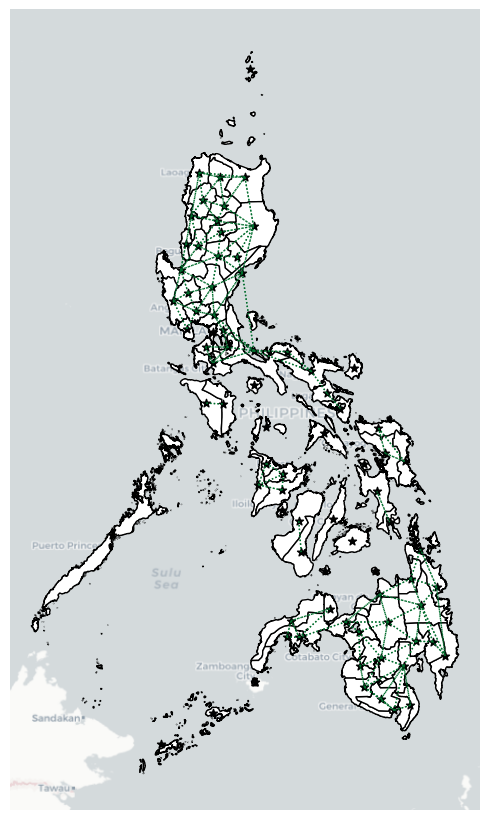

In [120]:
fig_1, ax_1 = plt.subplots(figsize=(5,14))
gdf.plot(ax=ax_1, facecolor='white', edgecolor='black')
wgt_dep.plot(gdf=gdf, ax=ax_1, edge_kws=dict(color=(0/255, 109/255, 44/255), linestyle=":", linewidth=1), node_kws=dict(marker="*"))

ctx.add_basemap(ax_1, source=cartodb_url, crs=gdf.crs.to_string())
ax_1.set_axis_off()
plt.tight_layout()
plt.savefig(f'outputs/neighboring.png', dpi=600, transparent=True)

#### Scale visualization

In [121]:
gdf_viz = gpd.GeoDataFrame(gdf_fin.copy(), geometry='geometry', crs='EPSG:4326')
gdf_viz_1 = gdf_viz.set_index('prov')

Function for choropleth map of province attributes

In [122]:
def geo_scale(df, data):
    fig = go.Figure(
        go.Choropleth(
            geojson=json.loads(df['geometry'].to_json()),
            locations=df.index,
            z=df[data],
            colorscale='Bluyl', 
            zmin=df[data].min(), 
            zmax=df[data].max(),
            marker_line_width=0.5,
            colorbar=dict(len=0.75, thickness=10, x=0.65, y=0.45)
        )
    )

    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(geo=dict(showframe=False, showcoastlines=False, bgcolor='rgba(0,0,0,0)'), 
                        plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)')
    fig.write_image(file=f'outputs/scale_{data}.png', format='png', scale=5)

    fig.show(renderer='png')


##### a. GDP per capita

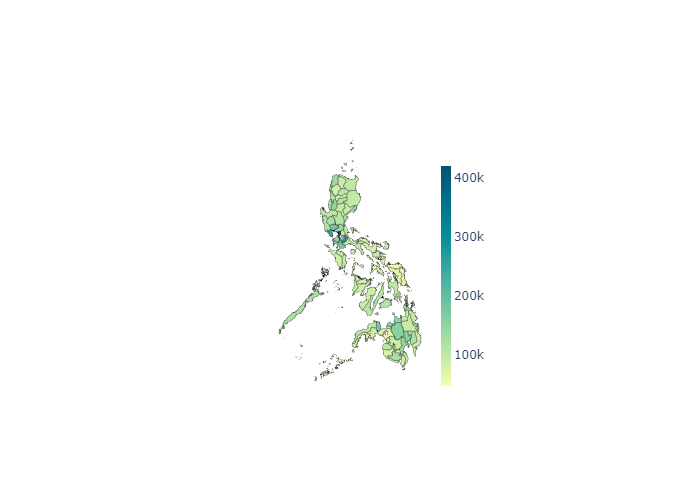

In [123]:
geo_scale(gdf_viz_1, 'gdp_pc')

##### b. Provincial GDP - Agriculture

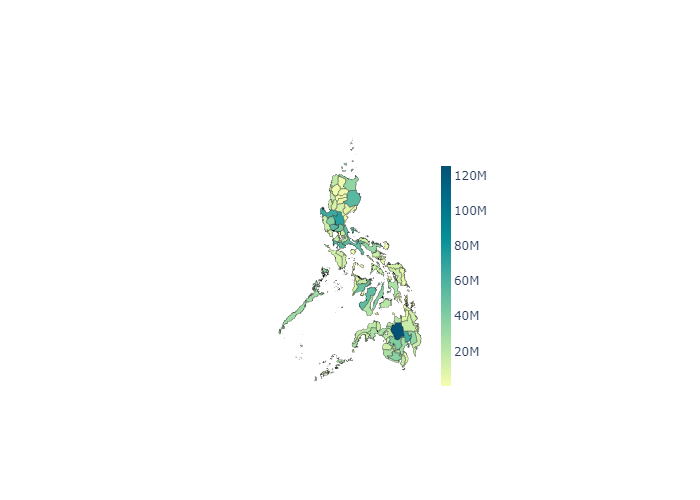

In [124]:
geo_scale(gdf_viz_1, 'gpdp_agri')

##### c. Provincial GDP - Industry

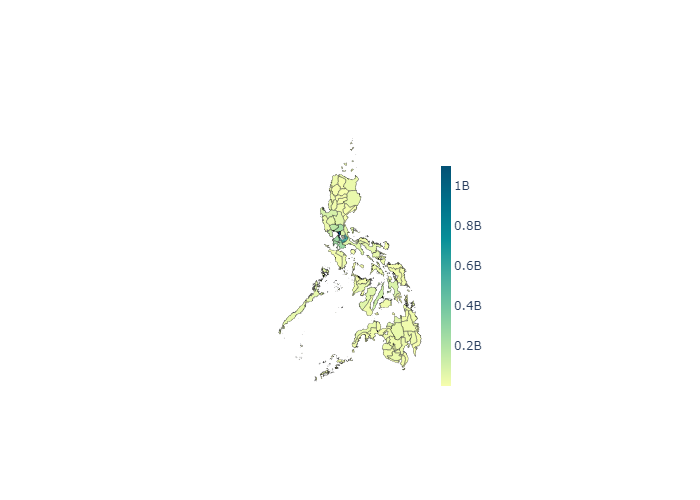

In [125]:
geo_scale(gdf_viz_1, 'gpdp_indu')

##### d. Provincial GDP -Services

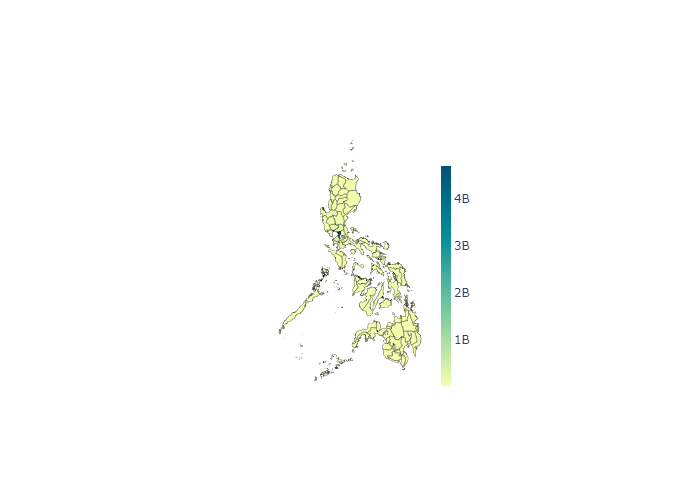

In [126]:
geo_scale(gdf_viz_1, 'gpdp_serv')

##### e. Population density

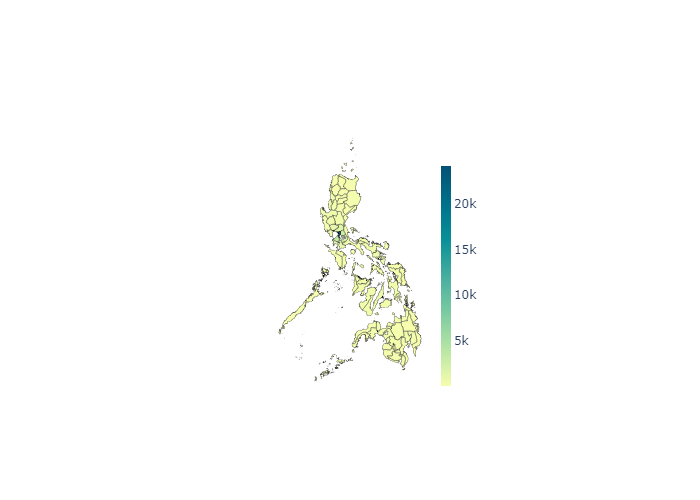

In [127]:
geo_scale(gdf_viz_1, 'pop_dens')

##### f. Road density

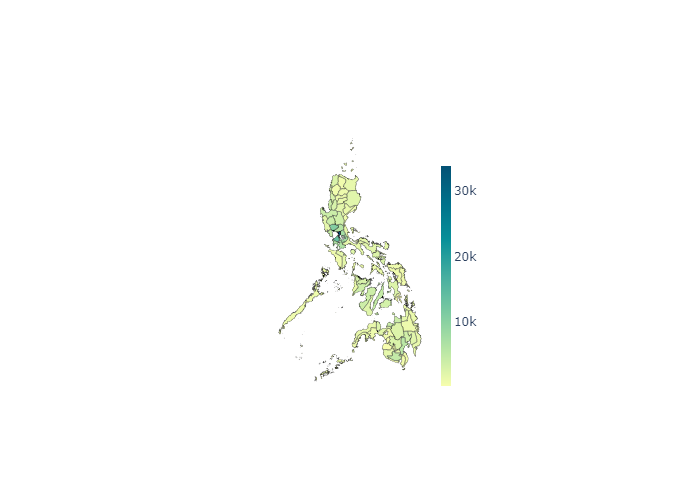

In [128]:
geo_scale(gdf_viz_1, 'road_dens')

##### g. Residential land use proportion

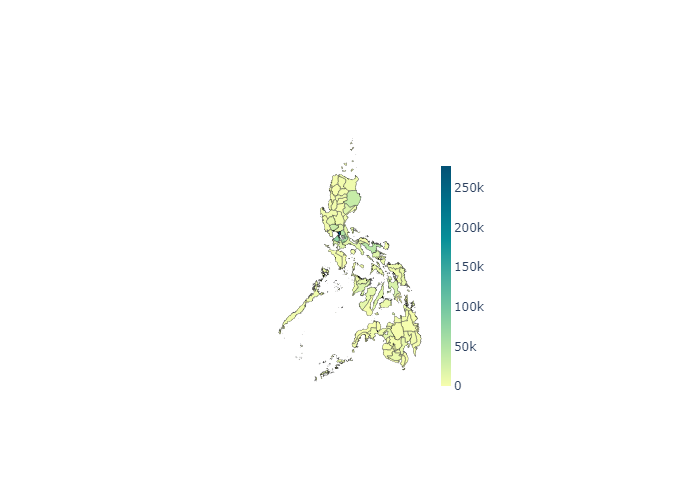

In [129]:
geo_scale(gdf_viz_1, 'hh_dens')

##### h. Dependable power supply

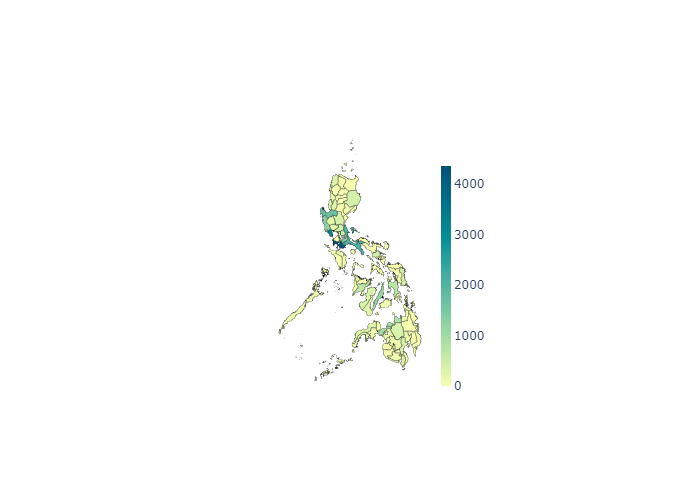

In [130]:
geo_scale(gdf_viz_1, 'pwr_dep_elp')

##### i. Water supply

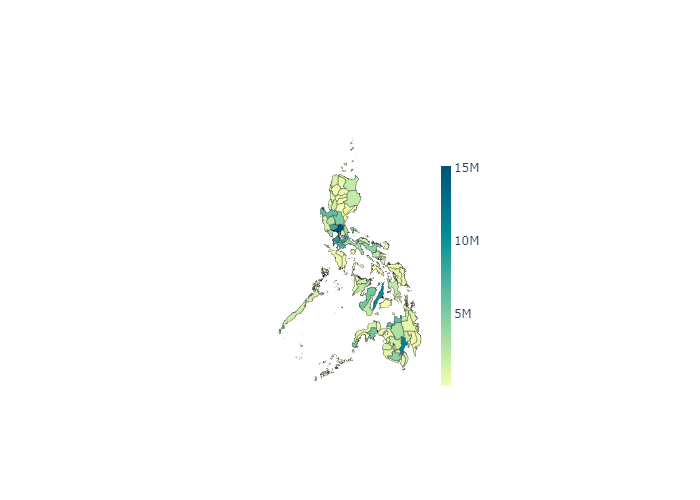

In [131]:
geo_scale(gdf_viz_1, 'water_prod')

##### j. Land surface temperature

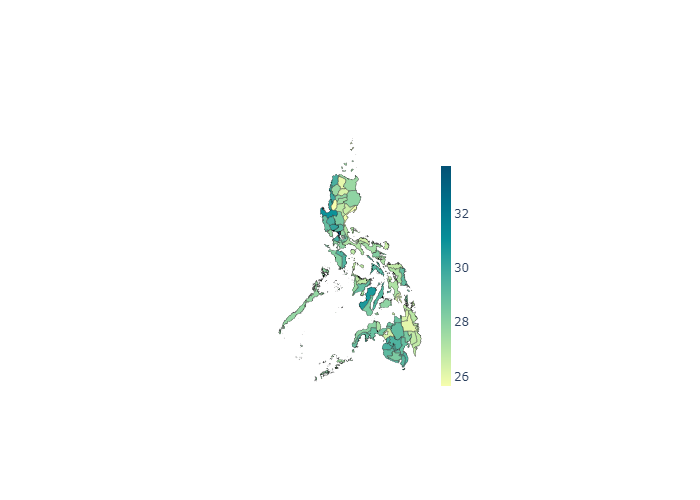

In [132]:
geo_scale(gdf_viz_1, 'lsat')

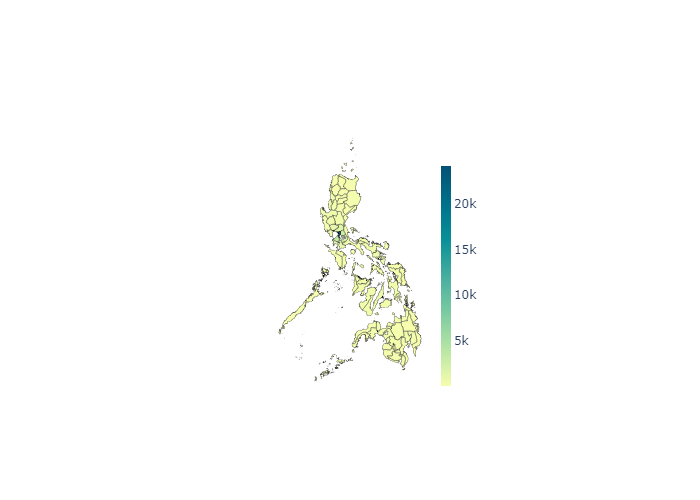

In [133]:
geo_scale(gdf_viz_1, 'pop_dens')

#### Global autocorrelation

In [134]:
glob_moran = esda.Moran(y=df['gdp_pc'], w=wgt_dep, permutations=9_999)
print(f'The global autocorrelation index of GDP per capita is {glob_moran.I:.2f} with {glob_moran.p_sim:.2f} p-value demonstrating existence of modest spatial relationship between provinces')

The global autocorrelation index of GDP per capita is 0.17 with 0.04 p-value demonstrating existence of modest spatial relationship between provinces


#### Local autocorrelation

Function for visualizing LISA

In [135]:
def create_loc_moran(df, col, w):
    local_moran = esda.Moran_Local(y=df[col], w=w, seed=300, permutations=9999)
    local_moran_I = local_moran.Is
    local_moran_sig = local_moran.p_sim
    fig_2, ax_2 = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
    
    ax_2 = ax_2.flatten()
    
    ax = ax_2[0]
    gdf.assign(Is=local_moran_I).plot(
        column='Is',
        cmap='coolwarm',
        scheme='quantiles',
        k=5,
        edgecolor='white',
        linewidth=0.15,
        alpha=0.85,
        legend=True,
        ax=ax
    )
    
    ax = ax_2[1]
    esdasplot.lisa_cluster(moran_loc=local_moran, gdf=gpd.GeoDataFrame(df), p=1, ax=ax, colormap='coolwarm_r')
    
    ax = ax_2[2]
    labels = pd.Series(1 * (local_moran_sig < 0.05), index=gpd.GeoDataFrame(df).index).map({1: 'Significant', 0: 'Non-Significant'})
    gpd.GeoDataFrame(df).assign(cl=labels).plot(
        column='cl',
        categorical=True,
        k=2,
        cmap='coolwarm',
        linewidth=0.15,
        edgecolor='white',
        legend=True,
        ax=ax,
    )
    
    ax = ax_2[3]
    esdasplot.lisa_cluster(moran_loc=local_moran, gdf=gpd.GeoDataFrame(df), p=0.05, ax=ax, colormap='coolwarm_r')
    
    for i, ax in enumerate(ax_2.flatten()):
        ax.set_axis_off()
        ax.set_title(
            [
                "Local Moran's I",
                "Scatterplot Quadrant",
                "Statistical Significance",
                "Moran Cluster Map",
            ][i],
            y=0,
        )
    
    fig_2.tight_layout()
    plt.savefig(f'outputs/local_moran_{col}.png', dpi=600, transparent=True)
    plt.show()

##### a. GDP per capita

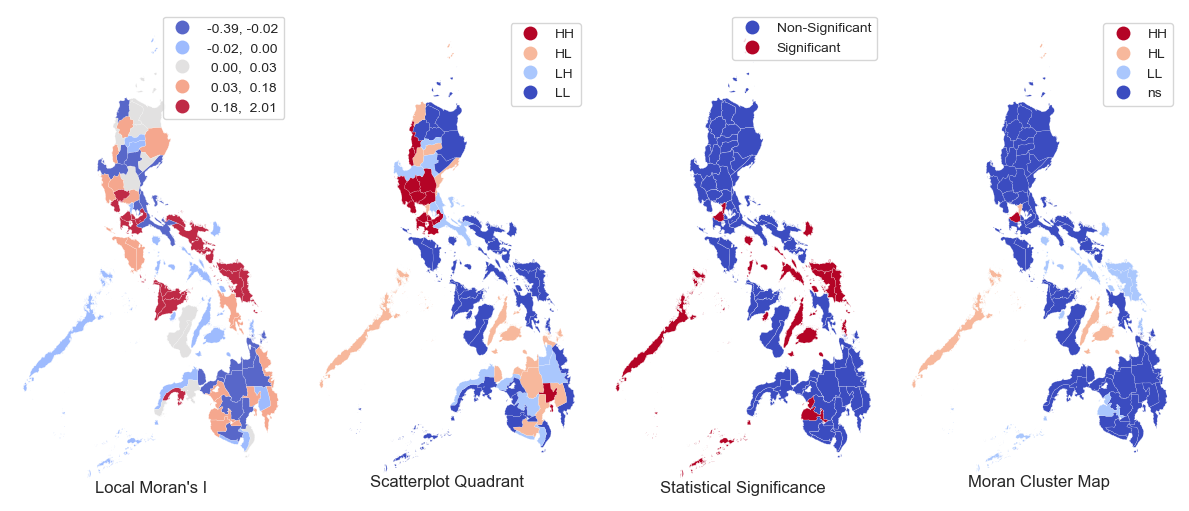

In [136]:
create_loc_moran(gdf_fin, 'gdp_pc', wgt_dep)

##### b. Provincial GDP - Agriculture

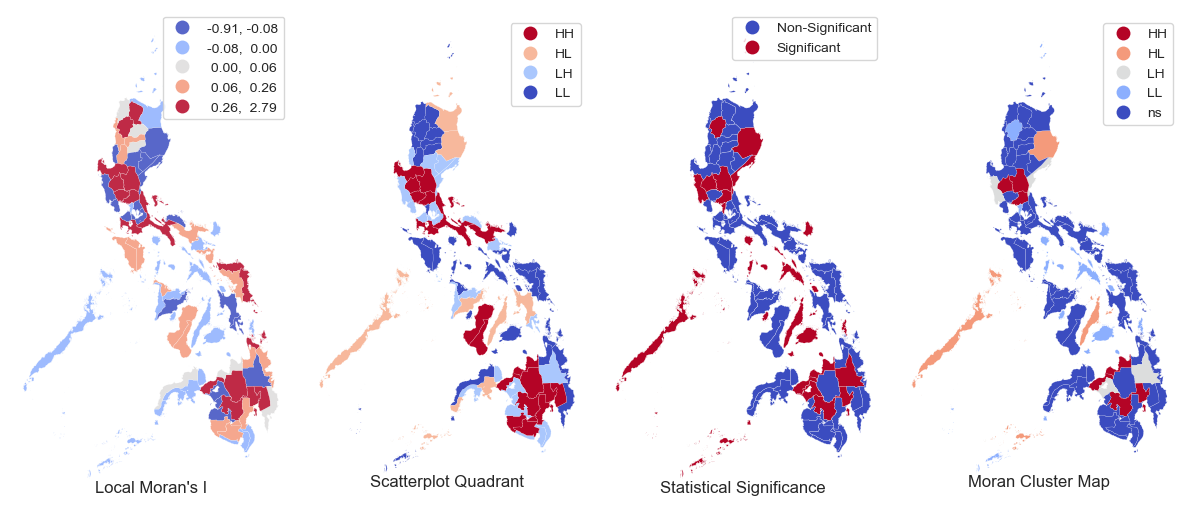

In [137]:
create_loc_moran(gdf_fin, 'gpdp_agri', wgt_dep)

##### c. Provincial GDP - Industry

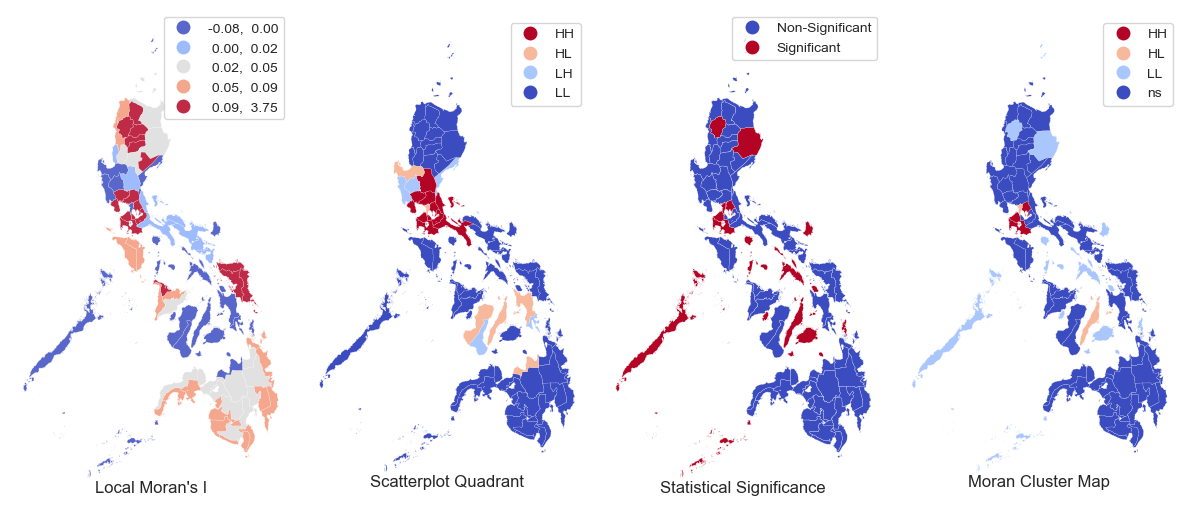

In [138]:
create_loc_moran(gdf_fin, 'gpdp_indu', wgt_dep)

##### d. Provincial GDP - Services

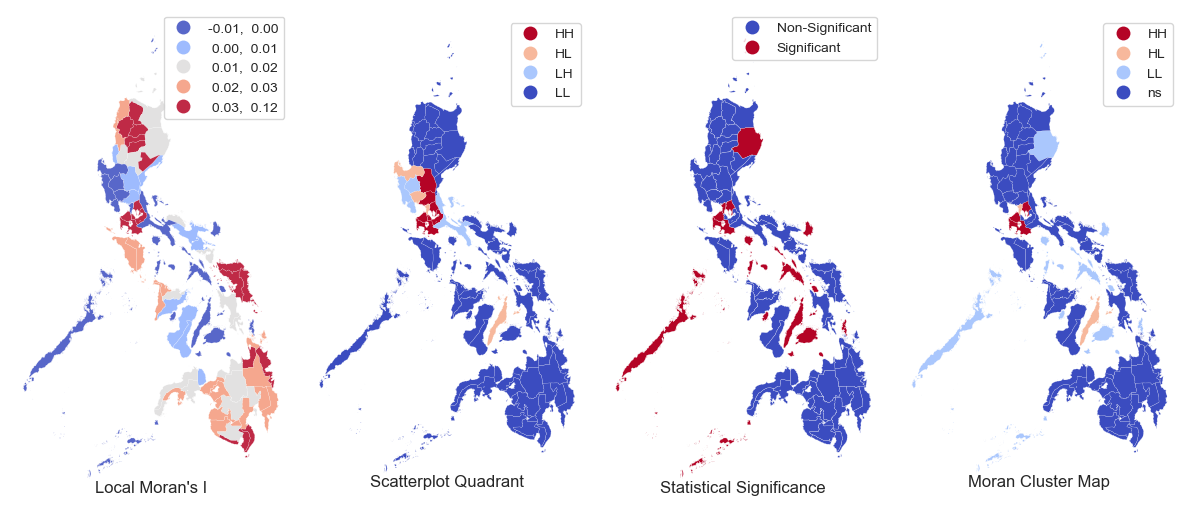

In [139]:
create_loc_moran(gdf_fin, 'gpdp_serv', wgt_dep)

##### e. Population density

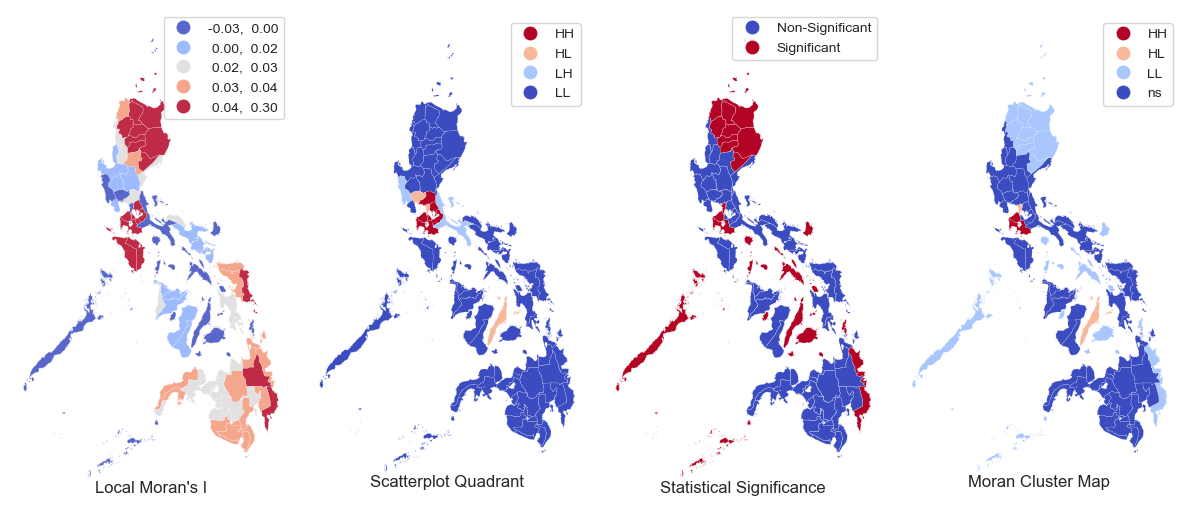

In [140]:
create_loc_moran(gdf_fin, 'pop_dens', wgt_dep)

##### f. Road density

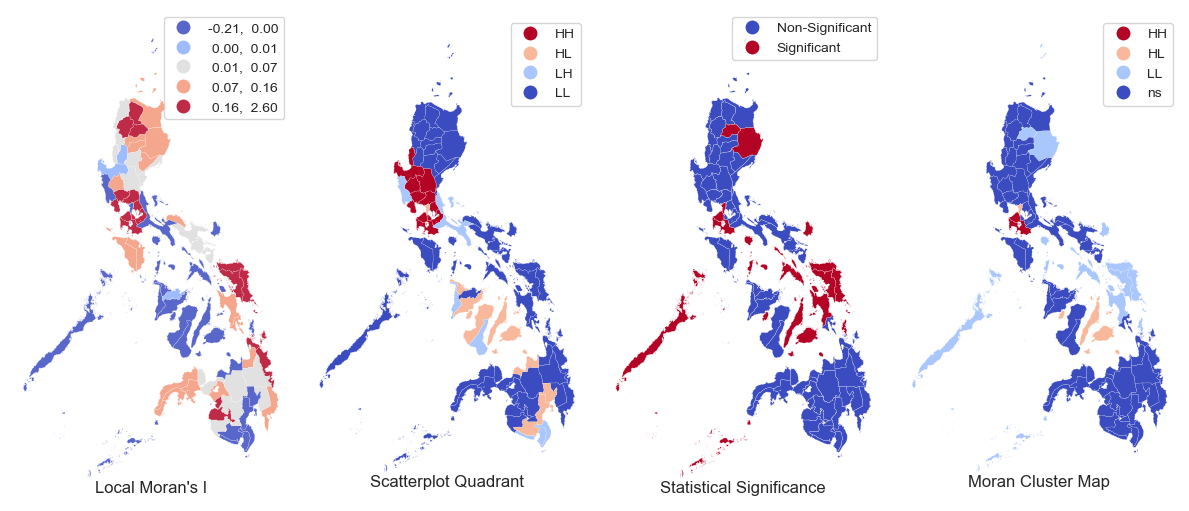

In [141]:
create_loc_moran(gdf_fin, 'road_dens', wgt_dep)

##### g. Residential land use proportion

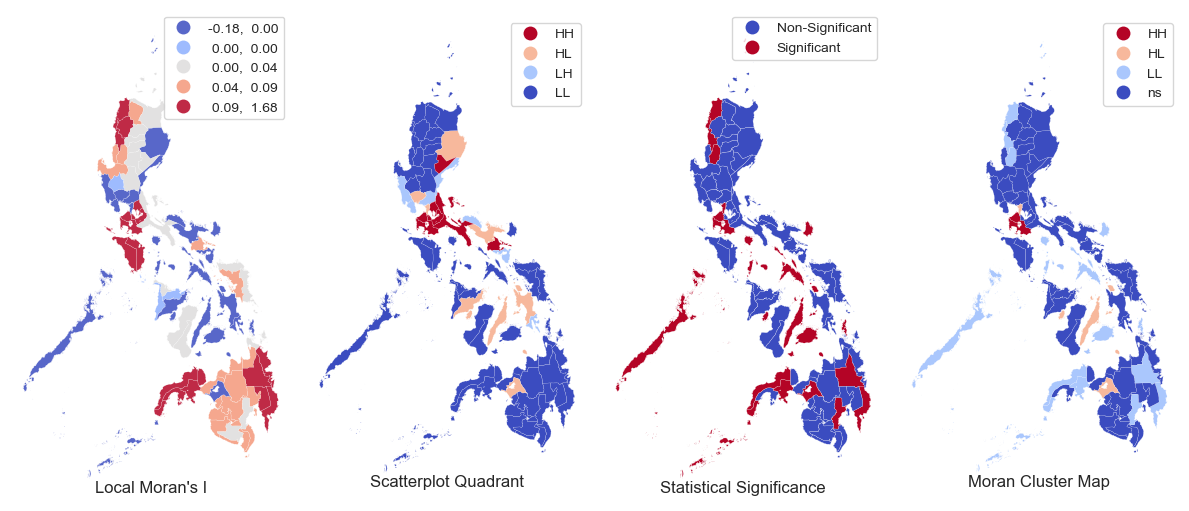

In [142]:
create_loc_moran(gdf_fin, 'hh_dens', wgt_dep)

##### h. Dependable power supply

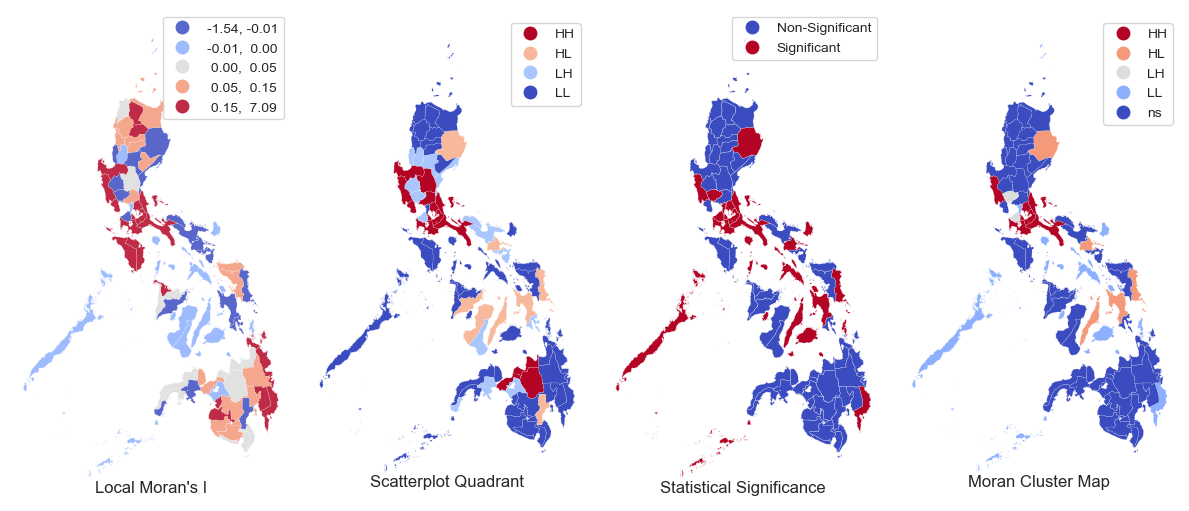

In [143]:
create_loc_moran(gdf_fin, 'pwr_dep_elp', wgt_dep)

##### i. Water supply

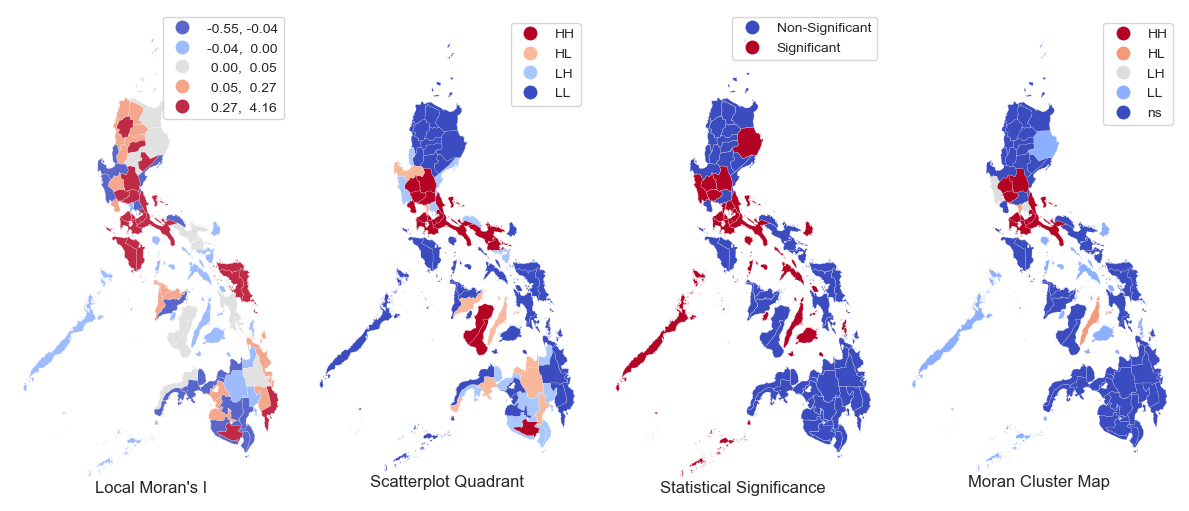

In [144]:
create_loc_moran(gdf_fin, 'water_prod', wgt_dep)

##### j. Land surface temperature

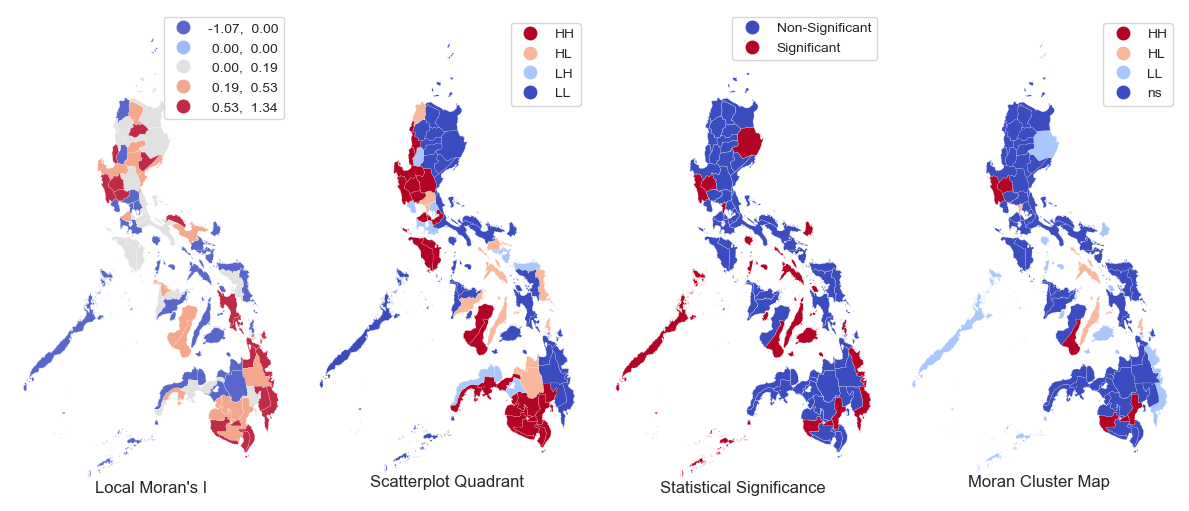

In [145]:
create_loc_moran(gdf_fin, 'lsat', wgt_dep)

#### LISA quadrant intersection - Logarithm of GDP per capita and land surface temperature to respective physical infrastructure (road density, dependable power supply, and water supply)

##### Geodataframe set-up

In [146]:
local_moran_q_excl = ['log_gdp_pc', 'prov', 'gpdp_agri', 'gpdp_indu', 'gpdp_serv', 'geometry', 'residuals']
for col in gdf_viz.columns:
    if col in local_moran_q_excl:
        pass
    else:
        local_moran = esda.Moran_Local(y=gdf_viz[col], w=wgt_dep, seed=300, permutations=9999)
        gdf_viz[f'moran_q_{col}'] = local_moran.q.tolist()

In [147]:
gdf_viz['moran_q_road_dens_int'] = 'Mix'
gdf_viz['moran_q_pwr_dep_elp_int'] = 'Mix'
gdf_viz['moran_q_water_prod_int'] = 'Mix'
for col in ['road_dens', 'pwr_dep_elp', 'water_prod']:
    gdf_viz.loc[((gdf_viz[f'moran_q_{col}'] == 2) | (gdf_viz[f'moran_q_{col}'] == 3) | (gdf_viz[f'moran_q_{col}'] == 4))\
                & ((gdf_viz[f'moran_q_gdp_pc'] == 2) | (gdf_viz[f'moran_q_gdp_pc'] == 3) | (gdf_viz[f'moran_q_gdp_pc'] == 4))\
                & ((gdf_viz[f'moran_q_lsat'] == 2) | (gdf_viz[f'moran_q_lsat'] == 3) | (gdf_viz[f'moran_q_lsat'] == 4)), f'moran_q_{col}_int'] = 'All low'
    gdf_viz.loc[(gdf_viz[f'moran_q_{col}'] == 1)\
                & (gdf_viz[f'moran_q_gdp_pc'] == 1)\
                & ((gdf_viz[f'moran_q_lsat'] == 2) | (gdf_viz[f'moran_q_lsat'] == 3) | (gdf_viz[f'moran_q_lsat'] == 4)), f'moran_q_{col}_int'] = 'Both High - Low LST'
    gdf_viz.loc[(gdf_viz[f'moran_q_{col}'] == 1)\
                & (gdf_viz[f'moran_q_gdp_pc'] == 1)\
                & (gdf_viz[f'moran_q_lsat'] == 1), f'moran_q_{col}_int'] = 'Both High - High LST'

In [148]:
gdf_viz['moran_q_allint'] = 'Mix'
gdf_viz.loc[((gdf_viz['moran_q_gdp_pc'] == 2) | (gdf_viz['moran_q_gdp_pc'] == 3) | (gdf_viz['moran_q_gdp_pc'] == 4))\
        & ((gdf_viz['moran_q_lsat'] == 2) | (gdf_viz['moran_q_lsat'] == 3) | (gdf_viz['moran_q_lsat'] == 4))\
        & ((gdf_viz['moran_q_road_dens'] == 2) | (gdf_viz['moran_q_road_dens'] == 3) | (gdf_viz['moran_q_road_dens'] == 4))\
        & ((gdf_viz['moran_q_pwr_dep_elp'] == 2) | (gdf_viz['moran_q_pwr_dep_elp'] == 3) | (gdf_viz['moran_q_pwr_dep_elp'] == 4))\
        & ((gdf_viz['moran_q_water_prod'] == 2) | (gdf_viz['moran_q_water_prod'] == 3) | (gdf_viz['moran_q_water_prod'] == 4)), f'moran_q_allint'] = 'All low'
gdf_viz.loc[(gdf_viz['moran_q_gdp_pc'] == 1)\
        & ((gdf_viz['moran_q_lsat'] == 2) | (gdf_viz['moran_q_lsat'] == 3) | (gdf_viz['moran_q_lsat'] == 4))\
        & (gdf_viz['moran_q_road_dens'] == 1)\
        & (gdf_viz['moran_q_pwr_dep_elp'] == 1)\
        & (gdf_viz['moran_q_water_prod'] == 1), f'moran_q_allint'] = 'All High - Low LST'
gdf_viz.loc[(gdf_viz['moran_q_gdp_pc'] == 1)\
        & (gdf_viz['moran_q_lsat'] == 1)\
        & (gdf_viz['moran_q_road_dens'] == 1)\
        & (gdf_viz['moran_q_pwr_dep_elp'] == 1)\
        & (gdf_viz['moran_q_water_prod'] == 1), f'moran_q_allint'] = 'All High - High LST'

##### Function for visualizing intersection of LISA quadrants

In [149]:
def moranq_int(df, data):
    fig = px.choropleth(data_frame=df,
                        geojson=json.loads(df[['geometry', 'prov']].to_json()),
                        color=data,
                        color_discrete_map={'All low': '#3B4CC0', 'Mix': '#769ED8',
                                                'Both High - Low LST': '#EFB8A1',
                                                'Both High - High LST': 'rgb(178,24,43)'},
                        locations=df.index,
                        featureidkey='properties.prov',
                        width=900,
                        height=650,
                        )
    
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(geo=dict(showframe=False, showcoastlines=False, bgcolor='rgba(0,0,0,0)'), 
                        plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)',
                        legend_title_text='',
                        legend=dict(x=0.65, y=0.65))
    fig.update_traces(marker_line_color='white', marker_line_width=0.3)
    fig.add_scattergeo(geojson=json.loads(df[['geometry', 'prov']].to_json()),
                       locations = df['prov'],
                       text = df['prov'],
                       featureidkey='properties.prov',
                       mode = 'text',
                       textfont=dict(family='Nirmala UI', size=3, color='rgb(247,251,255)')
                       )
    fig.update_traces(showlegend=False, selector=dict(type='scattergeo'))
    fig.write_image(file=f'outputs/{data}.png', format='png', scale=5)

    fig.show(renderer='png')


##### a. Road density

In [150]:
gdf_viz['moran_q_road_dens_int'].value_counts(sort=False, normalize=True)

moran_q_road_dens_int
All low                0.6585
Both High - Low LST    0.0366
Both High - High LST   0.0732
Mix                    0.2317
Name: proportion, dtype: float64

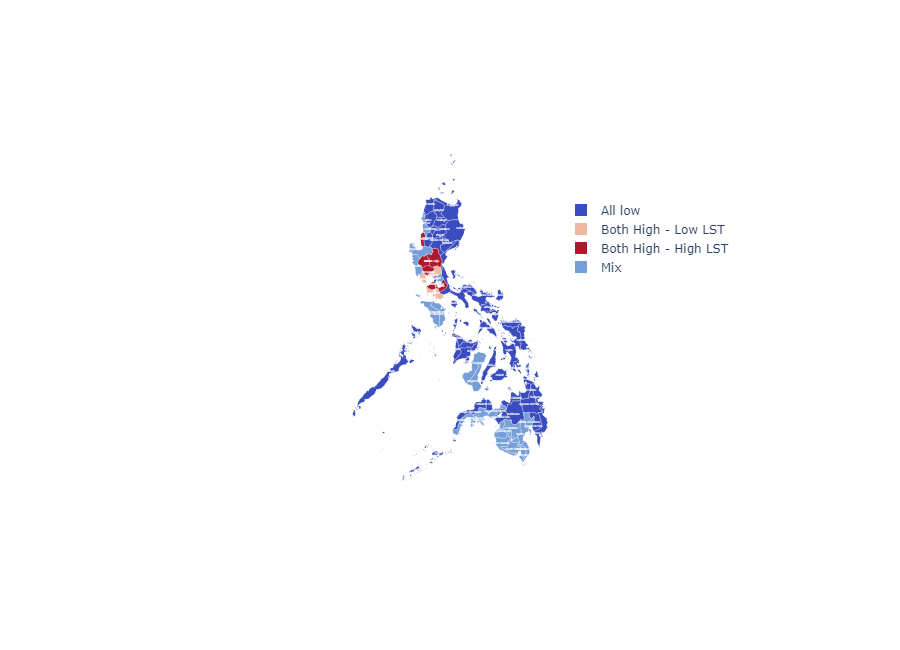

In [151]:
moranq_int(gdf_viz.copy().set_index('prov', drop=False), 'moran_q_road_dens_int')

##### b. Dependable power supply

In [152]:
gdf_viz['moran_q_pwr_dep_elp_int'].value_counts(sort=False, normalize=True)

moran_q_pwr_dep_elp_int
All low                0.6220
Both High - Low LST    0.0366
Mix                    0.3049
Both High - High LST   0.0366
Name: proportion, dtype: float64

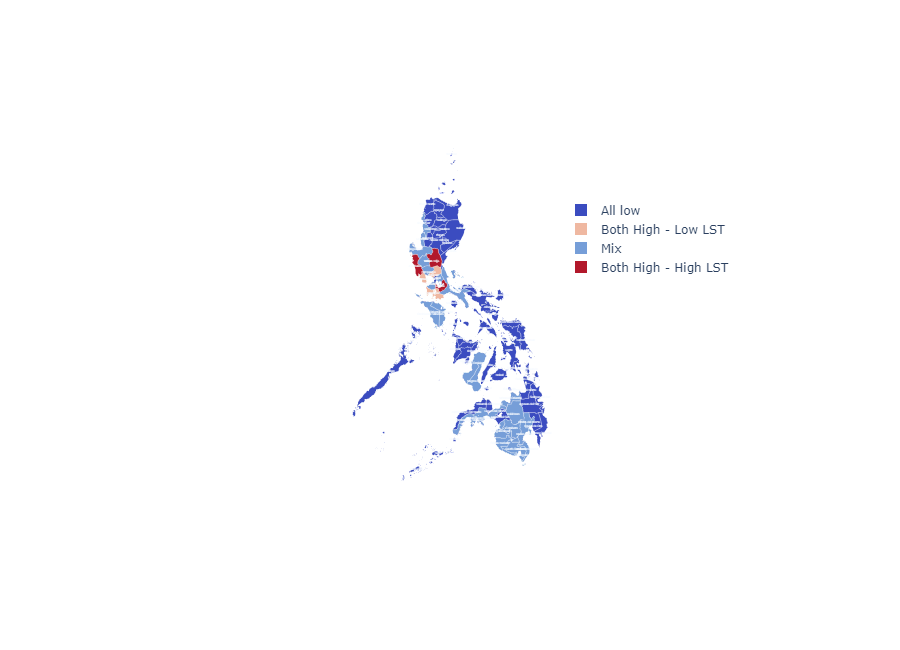

In [153]:
moranq_int(gdf_viz.copy().set_index('prov', drop=False), 'moran_q_pwr_dep_elp_int')

##### c. Water production

In [154]:
gdf_viz['moran_q_water_prod_int'].value_counts(sort=False, normalize=True)

moran_q_water_prod_int
All low                0.6341
Mix                    0.2683
Both High - Low LST    0.0366
Both High - High LST   0.0610
Name: proportion, dtype: float64

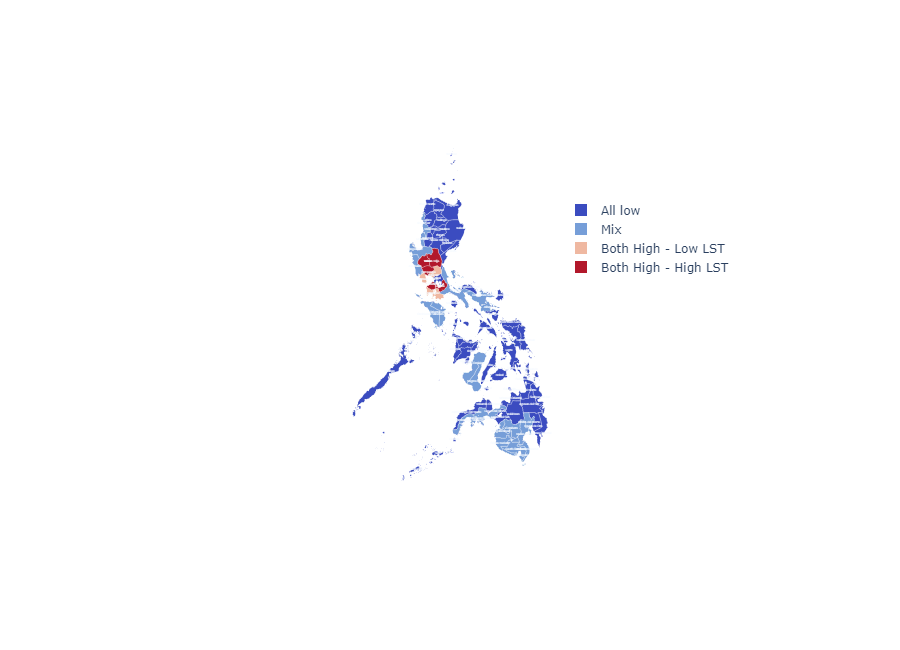

In [155]:
moranq_int(gdf_viz.copy().set_index('prov', drop=False), 'moran_q_water_prod_int')

In [156]:
gdf_viz['moran_q_allint'].value_counts(sort=False, normalize=True)

moran_q_allint
All low               0.5976
Mix                   0.3415
All High - Low LST    0.0366
All High - High LST   0.0244
Name: proportion, dtype: float64

In [157]:
def moranq_allint(df, data):
    fig = px.choropleth(data_frame=df,
                        geojson=json.loads(df[['geometry', 'prov']].to_json()),
                        color=data,
                        color_discrete_map={'All low': '#3B4CC0', 'Mix': '#769ED8',
                                                'All High - Low LST': '#EFB8A1',
                                                'All High - High LST': 'rgb(178,24,43)'},
                        locations=df.index,
                        featureidkey='properties.prov',
                        width=900,
                        height=650,
                        )
    
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(geo=dict(showframe=False, showcoastlines=False, bgcolor='rgba(0,0,0,0)'), 
                        plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)',
                        legend_title_text='',
                        legend=dict(x=0.65, y=0.65))
    fig.update_traces(marker_line_color='white', marker_line_width=0.3)
    fig.add_scattergeo(geojson=json.loads(df[['geometry', 'prov']].to_json()),
                       locations = df['prov'],
                       text = df['prov'],
                       featureidkey='properties.prov',
                       mode = 'text',
                       textfont=dict(family='Nirmala UI', size=3, color='rgb(247,251,255)')
                       )
    fig.update_traces(showlegend=False, selector=dict(type='scattergeo'))
    fig.write_image(file=f'outputs/{data}.png', format='png', scale=5)

    fig.show(renderer='png')


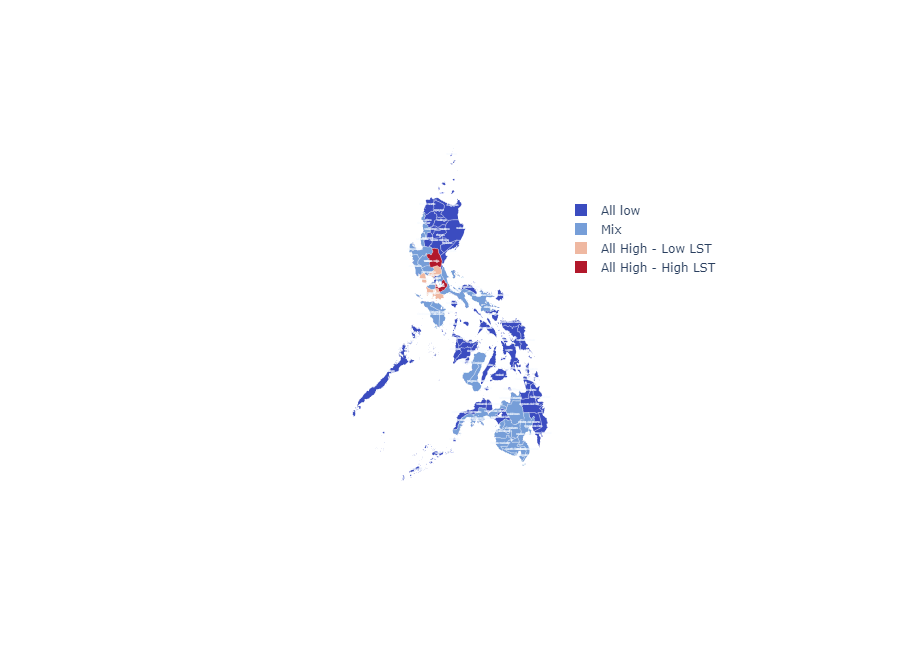

In [158]:
moranq_allint(gdf_viz.copy().set_index('prov', drop=False), 'moran_q_allint')

### Modelling

#### Spatial Lag Model

In [159]:
slx_pc = spreg.ML_Lag(y=gdf_dep_y.log_gdp_pc.values, x=gdf_dep_x.values, w=wgt_dep, vm=False,
                    name_y='log_gdp_pc', name_x=dep_var, name_w=dep_w_name, name_ds=ds)

In [160]:
print(slx_pc.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     ph_data
Weights matrix      :queen_contiguous
Dependent Variable  :  log_gdp_pc                Number of Observations:          82
Mean dependent var  :     11.5507                Number of Variables   :           8
S.D. dependent var  :      0.3552                Degrees of Freedom    :          74
Pseudo R-squared    :      0.5210
Spatial Pseudo R-squared:  0.5209
Log likelihood      :     -0.7909
Sigma-square ML     :      0.0597                Akaike info criterion :      17.582
S.E of regression   :      0.2443                Schwarz criterion     :      36.836

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [161]:
gdf_fin['residuals'] = slx_pc.u

In [162]:
for col in gdf_dep_x.columns:
    rho = kendalltau(slx_pc.u.reshape((82,)), np.array(gdf_fin[col]))[0]
    sig = kendalltau(slx_pc.u.reshape((82,)), np.array(gdf_fin[col]))[1]
    print(f'The correlation between IV: {col} and the residual is {rho:.2f} with p-value: {sig:.2f}')

The correlation between IV: hh_dens and the residual is -0.12 with p-value: 0.11
The correlation between IV: lsat and the residual is 0.02 with p-value: 0.82
The correlation between IV: pop_dens and the residual is -0.16 with p-value: 0.04
The correlation between IV: pwr_dep_elp and the residual is 0.02 with p-value: 0.76
The correlation between IV: road_dens and the residual is 0.02 with p-value: 0.76
The correlation between IV: water_prod and the residual is 0.03 with p-value: 0.72


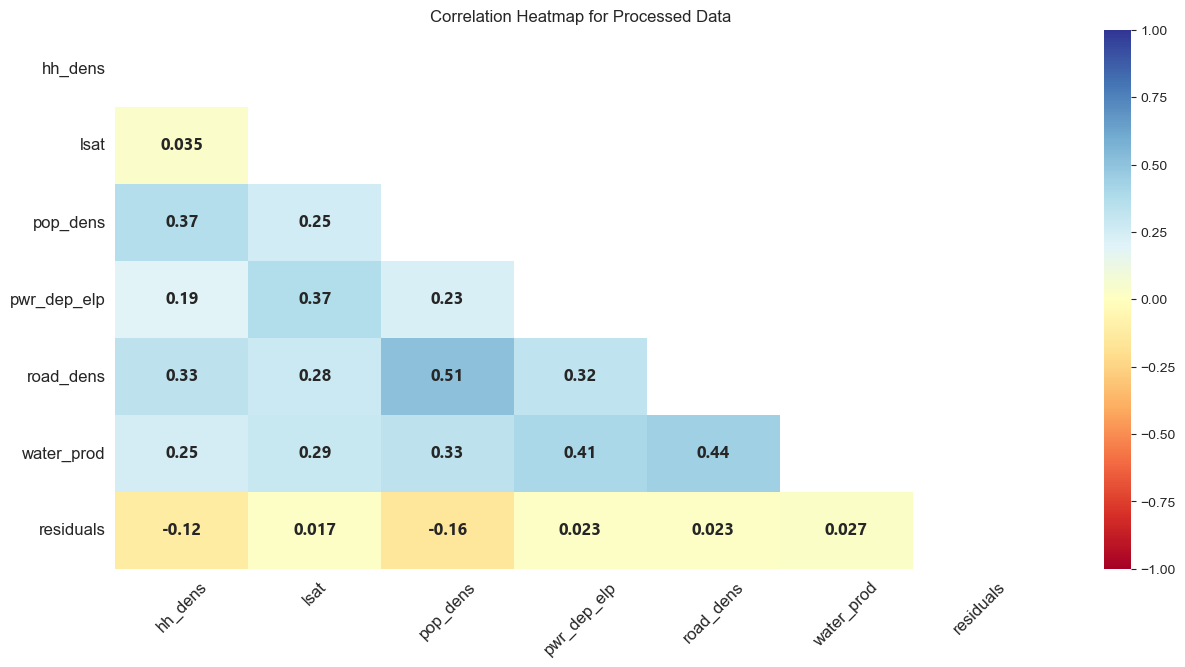

In [163]:
corr_mask_1 = np.triu(np.ones_like(gdf_fin.copy().drop(columns=['prov', 'log_gdp_pc', 'gdp_pc', 'gpdp_agri', 'gpdp_indu', 'gpdp_serv', 'geometry']).corr(method='kendall')))

fig_10, ax_10 = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
sns.heatmap(gdf_fin.copy().drop(columns=['prov', 'log_gdp_pc', 'gdp_pc', 'gpdp_agri', 'gpdp_indu', 'gpdp_serv', 'geometry']).corr(method='kendall'),
            ax=ax_10, cmap='RdYlBu', annot=True, vmin=-1, vmax=1, mask=corr_mask_1,
           annot_kws=dict(fontfamily="Nirmala UI", fontsize="large", fontweight="bold"))
ax_10.set_title("Correlation Heatmap for Processed Data")
ax_10.tick_params(axis="x", rotation=45, labelsize="large")
ax_10.tick_params(axis="y", rotation=0, labelsize="large")
fig_10.savefig('outputs/slx_residual_corr', dpi=600, transparent=True)

In [164]:
slx_pc.output

var_names coefficients std_err zt_stat   prob
0      CONSTANT      12.4658  0.7000 17.8092 0.0000
1       hh_dens      -0.0000  0.0000 -2.0163 0.0438
2          lsat      -0.0445  0.0256 -1.7395 0.0819
3      pop_dens       0.0000  0.0000  0.4330 0.6650
4   pwr_dep_elp       0.0001  0.0000  2.1989 0.0279
5     road_dens       0.0001  0.0000  4.1518 0.0000
6    water_prod       0.0000  0.0000  0.6465 0.5180
7  W_log_gdp_pc       0.0085  0.0061  1.3958 0.1628

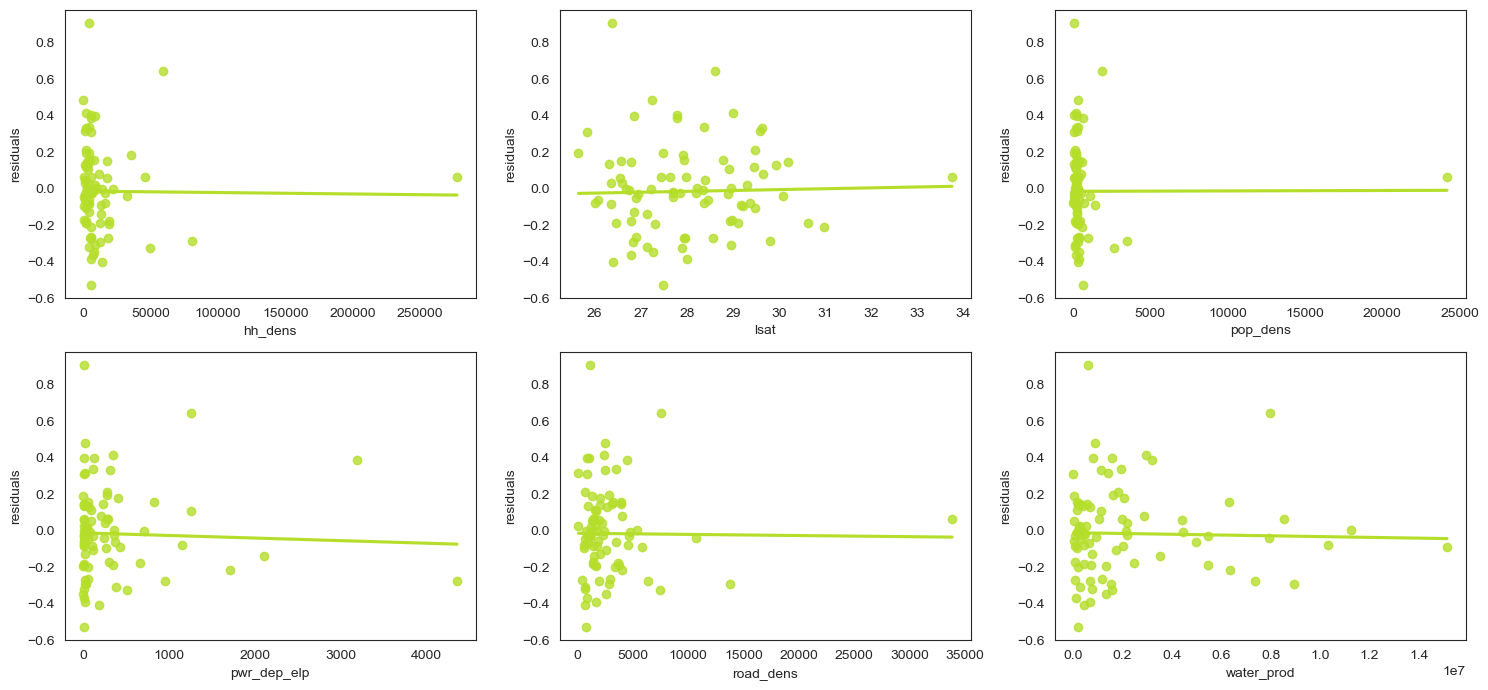

In [165]:
fig_9, ax_9 = plt.subplots(figsize=(15,7), nrows=2, ncols=3)
for i in range(gdf_dep_x.shape[1]):
    ax_9 = ax_9.flatten()
    ax = ax_9[i]
    sns.regplot(data=gdf_fin, x=gdf_fin.copy().drop(columns=['prov', 'log_gdp_pc', 'gdp_pc', 'gpdp_agri', 'gpdp_indu', 'gpdp_serv', 'geometry']).columns[i],
                    y='residuals', robust=True, color='#b5de2b', ax=ax, seed=300, ci=None)

fig_9.tight_layout()
fig_9.savefig('outputs/slx_residual_plot', dpi=600, transparent=True)